<a href="https://colab.research.google.com/github/ahmadrathore/Provisioning-SmartX-MicroBox/blob/master/Forecasting_NetworkFlows%5B2022-01-04%5D/GIST2020-12_Forecasting_Network_flows_LSTM_sequence_to_sequence_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Multivariate Multistep Time Series Forecasting using Stacked LSTM sequence to sequence Autoencoder in Tensorflow 2.0 / Keras 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from pandas import DataFrame
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot

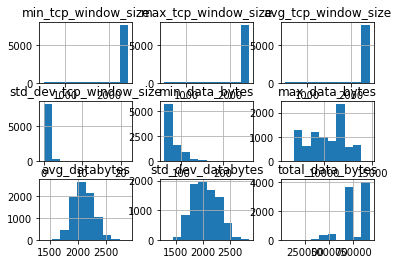

In [ ]:
url='https://raw.githubusercontent.com/ahmadrathore/Provisioning-SmartX-MicroBox/master/kafka9092_Network-Flows_1.csv'
#url='https://raw.githubusercontent.com/ahmadrathore/Provisioning-SmartX-MicroBox/master/kafka9092_Network-Flows_Moving_Average_reduced.csv'
#url='https://raw.githubusercontent.com/ahmadrathore/Provisioning-SmartX-MicroBox/master/http.csv'
#url='https://raw.githubusercontent.com/ahmadrathore/Provisioning-SmartX-MicroBox/master/Http_Https_Network-Flows_Smoothing.csv'
#url='https://raw.githubusercontent.com/ahmadrathore/Provisioning-SmartX-MicroBox/master/kafka9092_Network-Flows_Smoothing.csv'

df=pd.read_csv(url, sep=',', header=0, low_memory=False, infer_datetime_format=True, index_col=['Processing_time'], parse_dates=True)

df.head()
df.hist()
pyplot.show()

Downloading the dataset

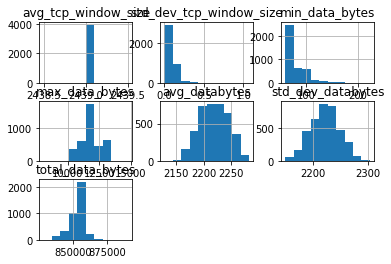

avg_tcp_window_size  ...  total_data_bytes
Processing_time                                        ...                  
2020-12-01 00:05:24.998000+09:00                 2439  ...         841409.62
2020-12-01 00:10:44.861000+09:00                 2439  ...         848574.18
2020-12-01 00:15:33.979000+09:00                 2439  ...         848582.98
2020-12-01 00:25:41.464000+09:00                 2439  ...         849091.56
2020-12-01 00:35:18.114000+09:00                 2439  ...         848334.18

[5 rows x 7 columns]

In [ ]:
#url='https://raw.githubusercontent.com/ahmadrathore/Provisioning-SmartX-MicroBox/master/kafka9092_Network-Flows_1.csv'
url='https://raw.githubusercontent.com/ahmadrathore/Provisioning-SmartX-MicroBox/master/kafka9092_Network-Flows_Moving_Average_reduced.csv'
#url='https://raw.githubusercontent.com/ahmadrathore/Provisioning-SmartX-MicroBox/master/http.csv'
#url='https://raw.githubusercontent.com/ahmadrathore/Provisioning-SmartX-MicroBox/master/Http_Https_Network-Flows_Smoothing.csv'
#url='https://raw.githubusercontent.com/ahmadrathore/Provisioning-SmartX-MicroBox/master/kafka9092_Network-Flows_Smoothing.csv'

df=pd.read_csv(url, sep=',', header=0, low_memory=False, infer_datetime_format=True, index_col=['Processing_time'], parse_dates=True)
df.hist()
pyplot.show()
df.head()



**Imputing Null values**

In [ ]:
df = df.replace('?', np.nan)
df.isnull().sum()

avg_tcp_window_size        0
std_dev_tcp_window_size    0
min_data_bytes             0
max_data_bytes             0
avg_databytes              0
std_dev_databytes          0
total_data_bytes           0
dtype: int64

In [ ]:
def fill_missing(values):
    one_day = 60*24
    for row in range(df.shape[0]):
        for col in range(df.shape[1]):
            if np.isnan(values[row][col]):
                values[row,col] = values[row-one_day,col]


#from sklearn.preprocessing import LabelEncoder
#for column in df.columns:
#    if df[column].dtype == type(object):
#        le = LabelEncoder()
#        df[column] = le.fit_transform(df[column])

df = df.astype('float32')
fill_missing(df.values)
df.isnull().sum()

avg_tcp_window_size        0
std_dev_tcp_window_size    0
min_data_bytes             0
max_data_bytes             0
avg_databytes              0
std_dev_databytes          0
total_data_bytes           0
dtype: int64

Downsampling of Data from minutes to Minutes/Hour(s)
 

In [ ]:
#daily_df = df.resample('0.1H').sum()
daily_df=df
index = daily_df.index
number_of_rows = len(index)
print (number_of_rows)
#daily_df = df


3922


In [ ]:
daily_df.head()

avg_tcp_window_size  ...  total_data_bytes
Processing_time                                        ...                  
2020-12-01 00:05:24.998000+09:00               2439.0  ...       841409.6250
2020-12-01 00:10:44.861000+09:00               2439.0  ...       848574.1875
2020-12-01 00:15:33.979000+09:00               2439.0  ...       848583.0000
2020-12-01 00:25:41.464000+09:00               2439.0  ...       849091.5625
2020-12-01 00:35:18.114000+09:00               2439.0  ...       848334.1875

[5 rows x 7 columns]

In [ ]:
daily_df.describe()

avg_tcp_window_size  ...  total_data_bytes
count               3922.0  ...       3922.000000
mean                2439.0  ...     853157.687500
std                    0.0  ...       5556.168945
min                 2439.0  ...     828991.500000
25%                 2439.0  ...     848977.390625
50%                 2439.0  ...     854634.062500
75%                 2439.0  ...     856088.640625
max                 2439.0  ...     889890.000000

[8 rows x 7 columns]

In [ ]:
daily_df.shape, df.shape

((3922, 7), (3922, 7))

       avg_tcp_window_size  ...  total_data_bytes
count               3922.0  ...       3922.000000
mean                2439.0  ...     853157.687500
std                    0.0  ...       5556.168945
min                 2439.0  ...     828991.500000
25%                 2439.0  ...     848977.390625
50%                 2439.0  ...     854634.062500
75%                 2439.0  ...     856088.640625
max                 2439.0  ...     889890.000000

[8 rows x 7 columns]


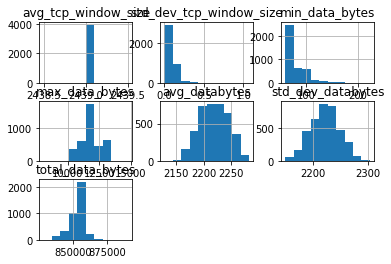

In [ ]:
#trans = StandardScaler()
#trans = MinMaxScaler()
#data = trans.fit_transform(daily_df)
# convert the array back to a dataframe
#dataset = DataFrame(data)
# summarize
#print(dataset.describe())
# histograms of the variables
#daily_df=dataset
#daily_df.columns = ['min_data_bytes','max_tcp_window_size','std_dev_tcp_window_size','max_tcp_window_size', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes']
print(daily_df.describe())
daily_df.hist()
pyplot.show()



In [ ]:
# For this case, let's assume that
# Given past 10 days observation, forecast the next 5 days observations. 
#n_past = 25
#n_future = 5 
#n_past = 24
#n_future =1

# Hours or Days Unit
#n_past = 24 # Total hours = 8500+, 168 hours = 7 days

n_past = 20
n_future = 10
#n_features =9

#n_past = 120
#n_future = 60

#n_past = 60
#n_future = 30
n_features =7

Train - Test Split

In [ ]:
#train_df,test_df = daily_df[1:5500], daily_df[5500:]  # 65% and 35% Unit is 5 min
#train_df,test_df = daily_df[1:8000], daily_df[8000:]  # 65% and 35% Unit is one Hour
#train_df,test_df = daily_df[1:982], daily_df[982:]  # 75% and 25% Unit is 30 min
train_df,test_df = daily_df[1:2549], daily_df[2549:]  # 65% and 35% Unit is one Hour
#train_df,test_df = daily_df[1:567], daily_df[567:]  # 75% and 25% Unit is one Hour
#train_df,test_df = daily_df[1:80], daily_df[80:]  # 75% and 25% Unit is 6 Hours
#train_df,test_df = daily_df[1:40], daily_df[40:]  # 75% and 25% Unit is 12 Hours,(63, 9)
#train_df,test_df = daily_df[1:245], daily_df[245:]  # 75% and 25% Unit is 2 Hours,(63, 9)
#train_df,test_df = daily_df[1:20], daily_df[20:]  # 75% and 25% in days
train_df.shape,test_df.shape

((2548, 7), (1373, 7))

In [ ]:
np.shape(train_df)


(2548, 7)

In [ ]:
np.shape(test_df)

(1373, 7)

Scaling the values for faster training of the models.

In [ ]:
train = train_df
scalers={}

for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s

test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

**Converting the series to samples for supervised learning**

In [ ]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)
  #return np.array(20), np.array(5)

In [ ]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [ ]:
X_test.shape

(1344, 20, 7)

In [ ]:
X_test

array([[[-1.00000000e+00, -8.67924511e-01, -9.75609839e-01, ...,
          1.59702301e-01,  1.48071289e-01, -5.00488281e-02],
        [-1.00000000e+00, -8.30188632e-01, -6.82926893e-01, ...,
          1.46591187e-01,  1.35011673e-01, -4.90493774e-02],
        [-1.00000000e+00, -7.54716992e-01, -5.60975671e-01, ...,
          8.91342163e-02,  9.77878571e-02, -3.76739502e-02],
        ...,
        [-1.00000000e+00, -8.30188632e-01, -1.00000000e+00, ...,
          9.88693237e-02,  1.55508041e-01, -3.65043640e-01],
        [-1.00000000e+00, -8.11320722e-01, -7.92683005e-01, ...,
          1.13895416e-01,  1.69528961e-01,  6.33239746e-04],
        [-1.00000000e+00, -8.11320722e-01, -8.53658617e-01, ...,
          2.07527161e-01,  2.32017517e-01, -1.83715820e-02]],

       [[-1.00000000e+00, -8.30188632e-01, -6.82926893e-01, ...,
          1.46591187e-01,  1.35011673e-01, -4.90493774e-02],
        [-1.00000000e+00, -7.54716992e-01, -5.60975671e-01, ...,
          8.91342163e-02,  9.77878571e

In [ ]:
y_test

array([[[-1.        , -0.83018863, -0.5121952 , ...,  0.2707863 ,
          0.29442215, -0.02536774],
        [-1.        , -0.11320752, -0.97560984, ...,  0.24206543,
          0.29681778, -0.01882935],
        [-1.        , -0.735849  , -0.95121956, ...,  0.38023376,
          0.45864487, -0.04532623],
        ...,
        [-1.        , -0.5660377 , -0.89024395, ...,  0.5258026 ,
          0.5336952 , -0.02187347],
        [-1.        , -0.83018863, -0.8536586 , ...,  0.44579697,
          0.49866867, -0.00909424],
        [-1.        , -1.        , -0.7317074 , ...,  0.40742493,
          0.46516228,  0.37041092]],

       [[-1.        , -0.11320752, -0.97560984, ...,  0.24206543,
          0.29681778, -0.01882935],
        [-1.        , -0.735849  , -0.95121956, ...,  0.38023376,
          0.45864487, -0.04532623],
        [-1.        , -0.67924523, -0.97560984, ...,  0.479084  ,
          0.5326748 , -0.05150223],
        ...,
        [-1.        , -0.83018863, -0.8536586 , ...,  

**Model Architecture**

E1D1 ==> Sequence to Sequence Model with one encoder layer and one decoder layer. 

E2D2 ==> Sequence to Sequence Model with two encoder layers and two decoder layers. 

In [ ]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)
#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)
#
model_e1d1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 20, 7)]      0                                            
__________________________________________________________________________________________________
lstm_6 (LSTM)                   [(None, 100), (None, 43200       input_3[0][0]                    
__________________________________________________________________________________________________
repeat_vector_2 (RepeatVector)  (None, 10, 100)      0           lstm_6[0][0]                     
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 10, 100)      80400       repeat_vector_2[0][0]            
                                                                 lstm_6[0][1]               

In [ ]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 20, 7)]      0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 20, 100), (N 43200       input_4[0][0]                    
__________________________________________________________________________________________________
lstm_9 (LSTM)                   [(None, 100), (None, 80400       lstm_8[0][0]                     
__________________________________________________________________________________________________
repeat_vector_3 (RepeatVector)  (None, 10, 100)      0           lstm_9[0][0]                     
____________________________________________________________________________________________

In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])


 **Training the models**


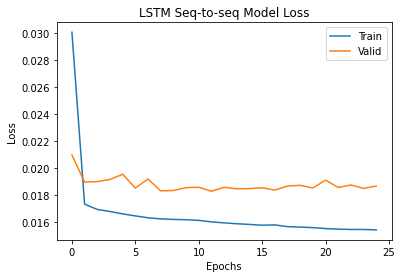

In [ ]:
plt.plot(history_e1d1.history['loss'])
plt.plot(history_e1d1.history['val_loss'])
plt.title("LSTM Seq-to-seq Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

In [ ]:
history_e1d1.history['loss'],history_e1d1.history['val_loss']

([0.030063819140195847,
  0.017311448231339455,
  0.016918867826461792,
  0.016768373548984528,
  0.016588902100920677,
  0.01643943414092064,
  0.01630145125091076,
  0.016219889745116234,
  0.016178162768483162,
  0.016157934442162514,
  0.01610901765525341,
  0.015997251495718956,
  0.015924090519547462,
  0.015857651829719543,
  0.015808267518877983,
  0.015750393271446228,
  0.01577196642756462,
  0.01564200408756733,
  0.0156105300411582,
  0.015571033582091331,
  0.015501188114285469,
  0.015459147281944752,
  0.015433311462402344,
  0.01543323416262865,
  0.015400786884129047],
 [0.02096167951822281,
  0.018946416676044464,
  0.018986552953720093,
  0.019140319898724556,
  0.019533297047019005,
  0.018505461513996124,
  0.019175762310624123,
  0.018296677619218826,
  0.01832455024123192,
  0.018535802140831947,
  0.018566403537988663,
  0.018269171938300133,
  0.018559731543064117,
  0.018448127433657646,
  0.018465029075741768,
  0.018526438623666763,
  0.01835639588534832,
  

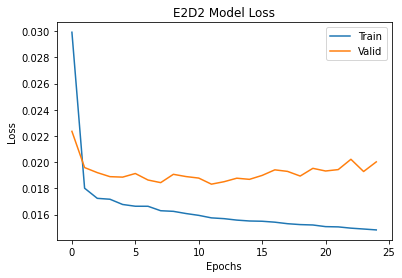

In [ ]:
plt.plot(history_e2d2.history['loss'])
plt.plot(history_e2d2.history['val_loss'])
plt.title("E2D2 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

Prediction on validation set

In [ ]:
pred1_e1d1=model_e1d1.predict(X_test)
pred1_e2d2=model_e2d2.predict(X_test)

pred_e1d1=model_e1d1.predict(X_train)
pred_e2d2=model_e2d2.predict(X_train)

Inverse Scaling of the predicted values

In [ ]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred1_e1d1[:,:,index]=scaler.inverse_transform(pred1_e1d1[:,:,index])
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    
    pred1_e2d2[:,:,index]=scaler.inverse_transform(pred1_e2d2[:,:,index])
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [ ]:
#def mean_absolute_percentage_error(y_true, y_pred): 
        #y_true, y_pred = np.array(y_true), np.array(y_pred)
        #return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    #print('Evaluation metric results:-')
    #print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    #print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    #print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    #print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    #print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

**Checking Error** 

avg_tcp_window_size

Day  1 :
MAE-E1D1 :  0.0068310327,     MAE-E2D2 :  0.010381426
[2439. 2439. 2439. ... 2439. 2439. 2439.]
[2438.9941 2438.9915 2439.0063 ... 2439.0083 2439.0059 2439.007 ]
MSE-E1D1 :  6.818244e-05, MSE-E2D2 :  0.00016985399
RMSE-E1D1 :  0.008257266,     NRMSE-E1D1 :  5.343486e-06,     RMSE-E2D2 :  0.013032804
MAPE-E1D1 :  0.00028007514174532844,     MAPE-E2D2 :  0.0004256427018844988
R2 is  :  0.0


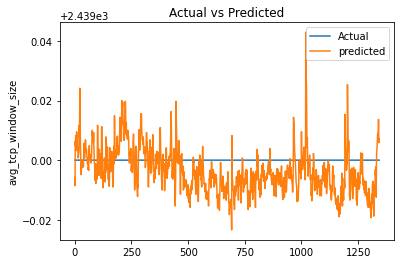

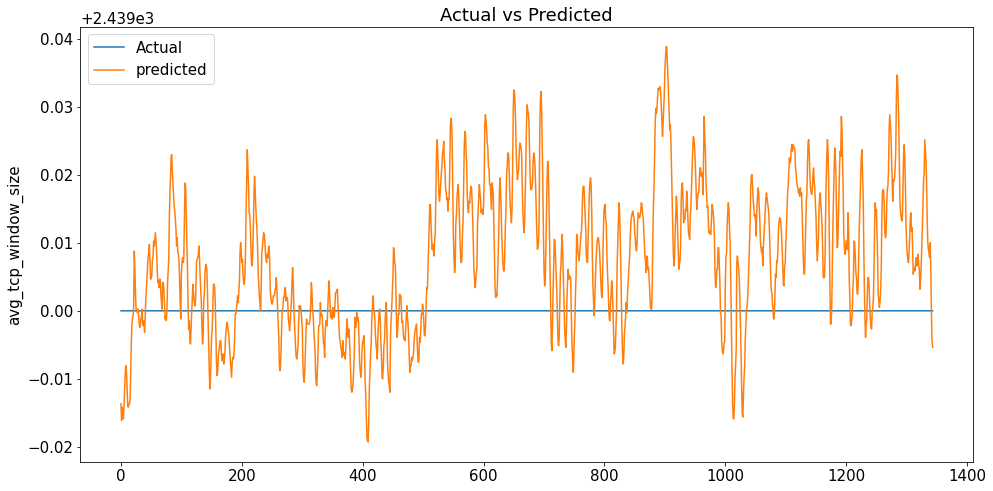


Day  2 :
MAE-E1D1 :  0.004447574,     MAE-E2D2 :  0.0070363
[2439. 2439. 2439. ... 2439. 2439. 2439.]
[2438.998  2438.9963 2439.0063 ... 2438.9978 2438.9946 2438.9941]
MSE-E1D1 :  3.3172204e-05, MSE-E2D2 :  8.305947e-05
RMSE-E1D1 :  0.0057595316,     NRMSE-E1D1 :  3.7366456e-06,     RMSE-E2D2 :  0.009113697
MAPE-E1D1 :  0.00018235233483210322,     MAPE-E2D2 :  0.0002884911964429193
R2 is  :  0.0


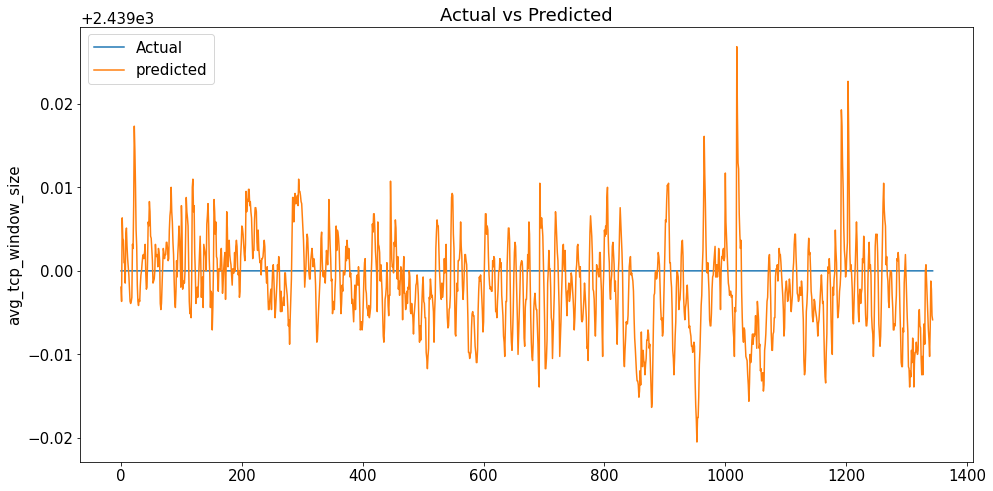

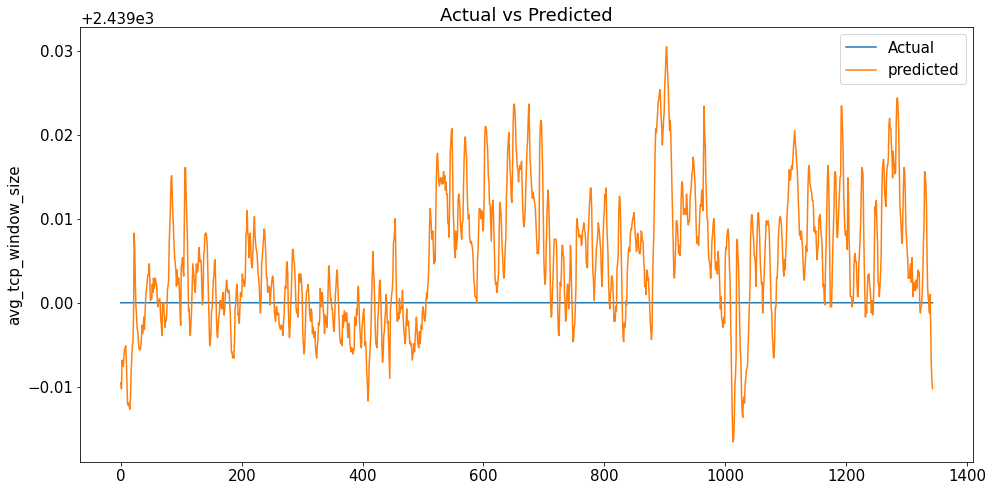


Day  3 :
MAE-E1D1 :  0.004714784,     MAE-E2D2 :  0.005546933
[2439. 2439. 2439. ... 2439. 2439. 2439.]
[2438.9988 2438.997  2439.0044 ... 2438.994  2438.9915 2438.9912]
MSE-E1D1 :  3.8685852e-05, MSE-E2D2 :  5.3102947e-05
RMSE-E1D1 :  0.006219795,     NRMSE-E1D1 :  2.9877674e-06,     RMSE-E2D2 :  0.007287177
MAPE-E1D1 :  0.00019330809664097615,     MAPE-E2D2 :  0.0002274265398227726
R2 is  :  0.0


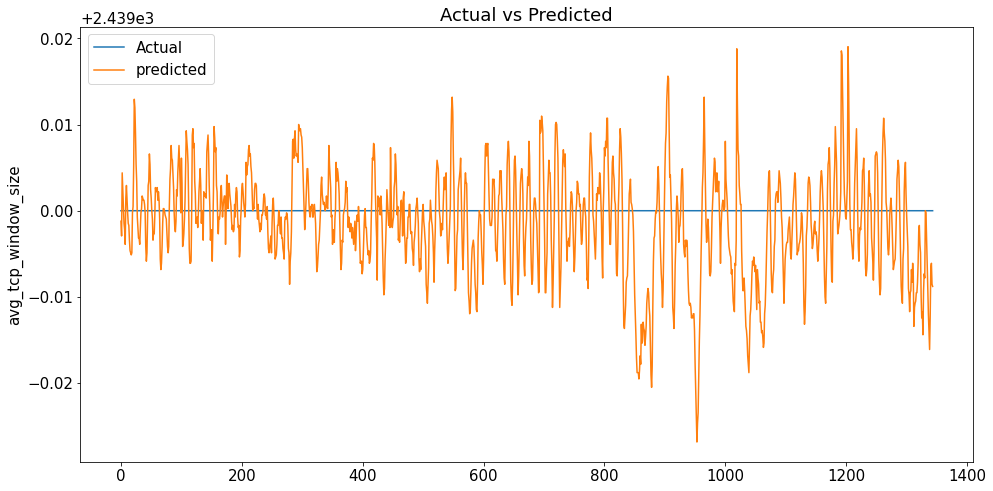

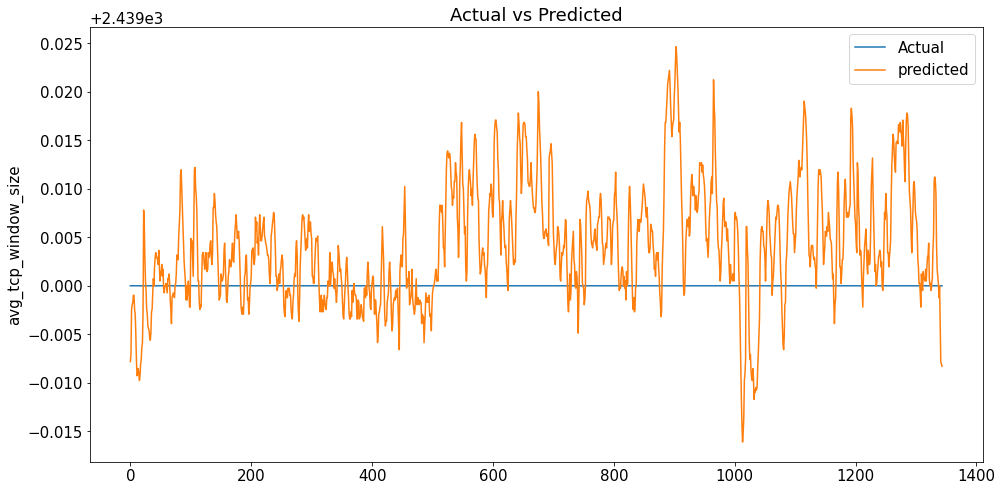


Day  4 :
MAE-E1D1 :  0.0045698257,     MAE-E2D2 :  0.0049898056
[2439. 2439. 2439. ... 2439. 2439. 2439.]
[2438.9998 2438.998  2439.004  ... 2438.9927 2438.9917 2438.993 ]
MSE-E1D1 :  3.7076705e-05, MSE-E2D2 :  4.2302134e-05
RMSE-E1D1 :  0.0060890643,     NRMSE-E1D1 :  2.6666662e-06,     RMSE-E2D2 :  0.006504009
MAPE-E1D1 :  0.00018736473066383041,     MAPE-E2D2 :  0.00020458408016565954
R2 is  :  0.0


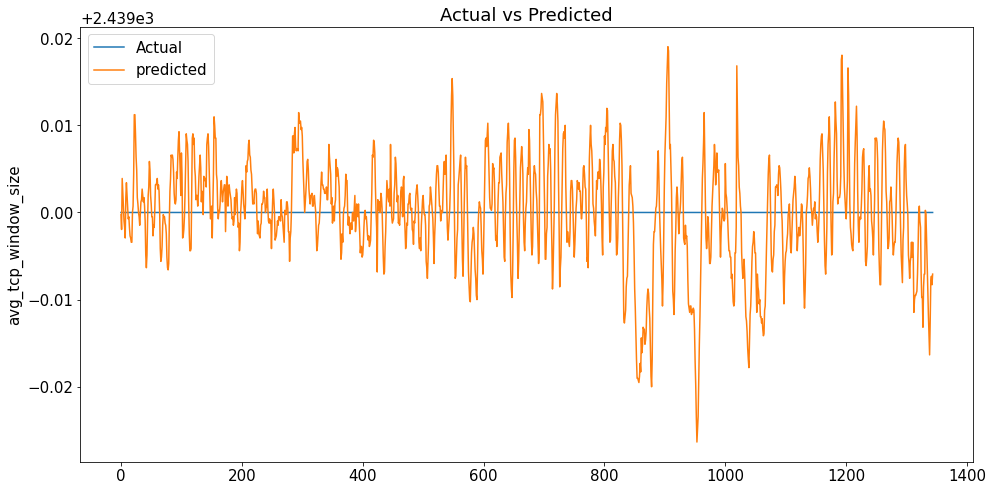

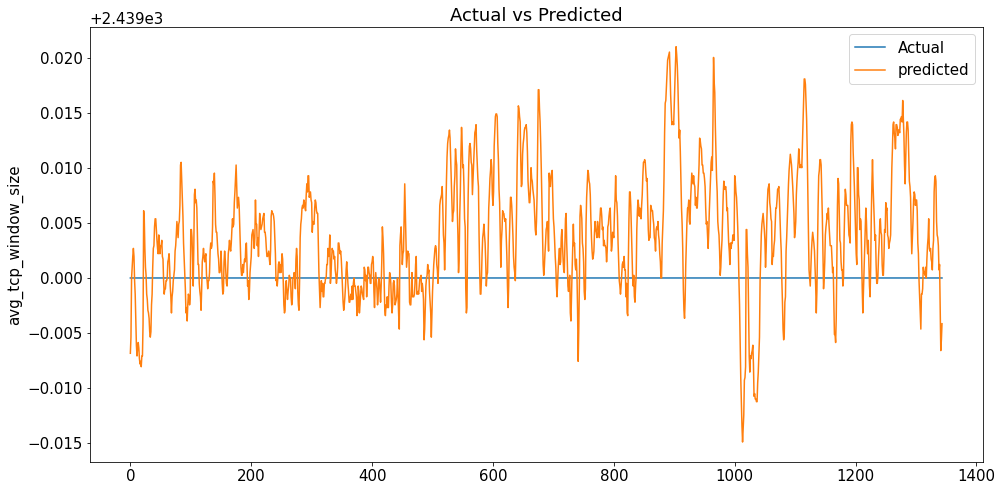


Day  5 :
MAE-E1D1 :  0.0045002527,     MAE-E2D2 :  0.004843939
[2439. 2439. 2439. ... 2439. 2439. 2439.]
[2439.     2438.9983 2439.0034 ... 2438.9922 2438.9927 2438.995 ]
MSE-E1D1 :  3.5169225e-05, MSE-E2D2 :  3.87628e-05
RMSE-E1D1 :  0.0059303646,     NRMSE-E1D1 :  2.5526726e-06,     RMSE-E2D2 :  0.0062259776
MAPE-E1D1 :  0.00018451222558724112,     MAPE-E2D2 :  0.00019860349311784375
R2 is  :  0.0


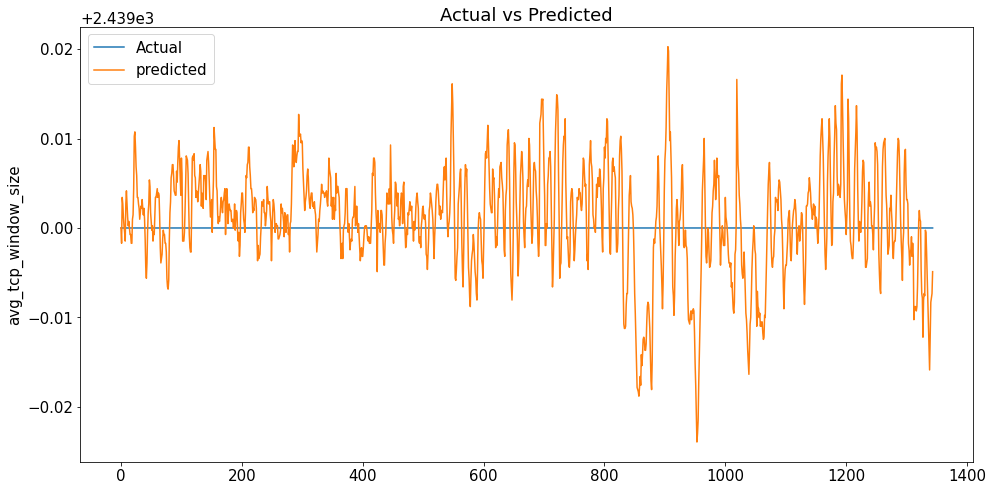

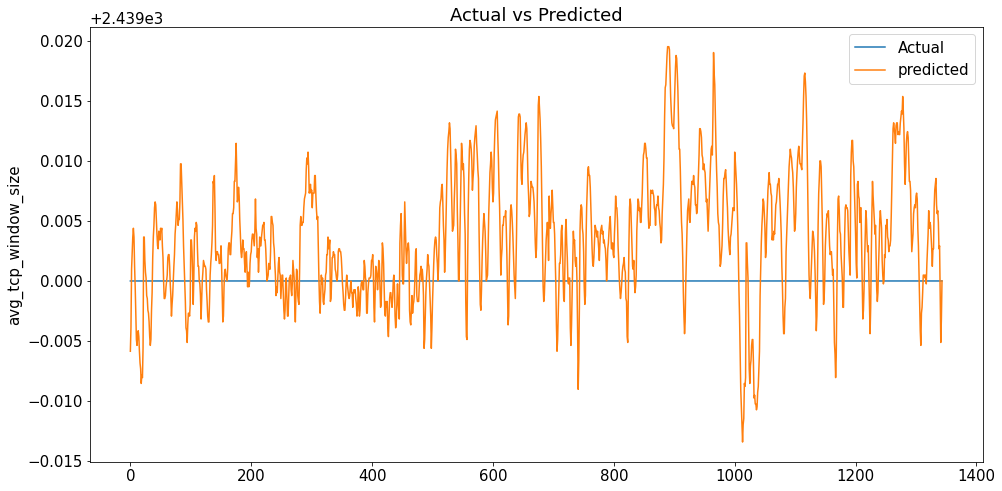



std_dev_tcp_window_size

Day  1 :
MAE-E1D1 :  0.043018274,     MAE-E2D2 :  0.04323428
[0.09000002 0.47       0.14000002 ... 0.04999999 0.04999999 0.07000001]
[0.08343603 0.08440626 0.09590162 ... 0.09294381 0.11568825 0.13376765]
MSE-E1D1 :  0.0058036014, MSE-E2D2 :  0.0057421136
RMSE-E1D1 :  0.076181374,     NRMSE-E1D1 :  0.84734327,     RMSE-E2D2 :  0.07577673
MAPE-E1D1 :  inf,     MAPE-E2D2 :  inf
R2 is  :  -0.026427536944394703


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


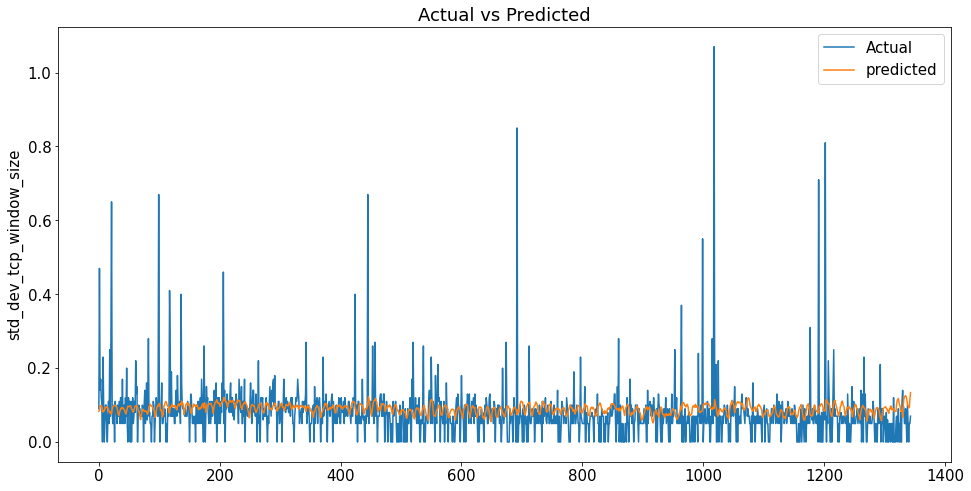

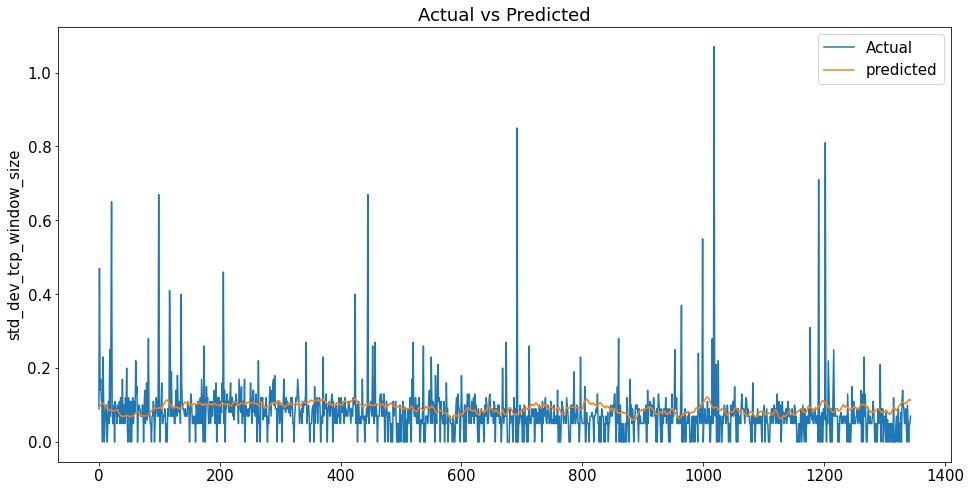


Day  2 :
MAE-E1D1 :  0.043021828,     MAE-E2D2 :  0.04386771
[0.47       0.14000002 0.17000002 ... 0.04999999 0.07000001 0.07000001]
[0.08974382 0.09078681 0.09700792 ... 0.09825865 0.10938813 0.11639499]
MSE-E1D1 :  0.0057631144, MSE-E2D2 :  0.005796204
RMSE-E1D1 :  0.07591518,     NRMSE-E1D1 :  0.83475286,     RMSE-E2D2 :  0.076132804
MAPE-E1D1 :  inf,     MAPE-E2D2 :  inf
R2 is  :  -0.036101586331095836


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


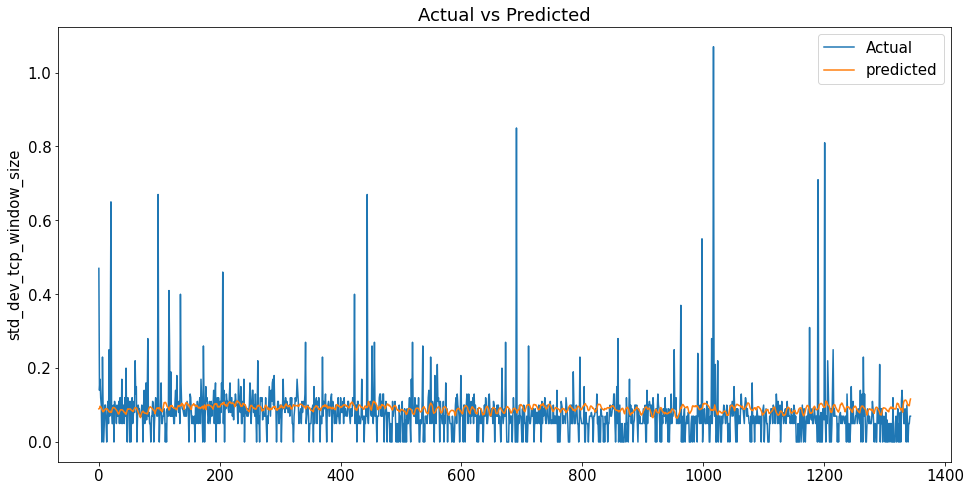

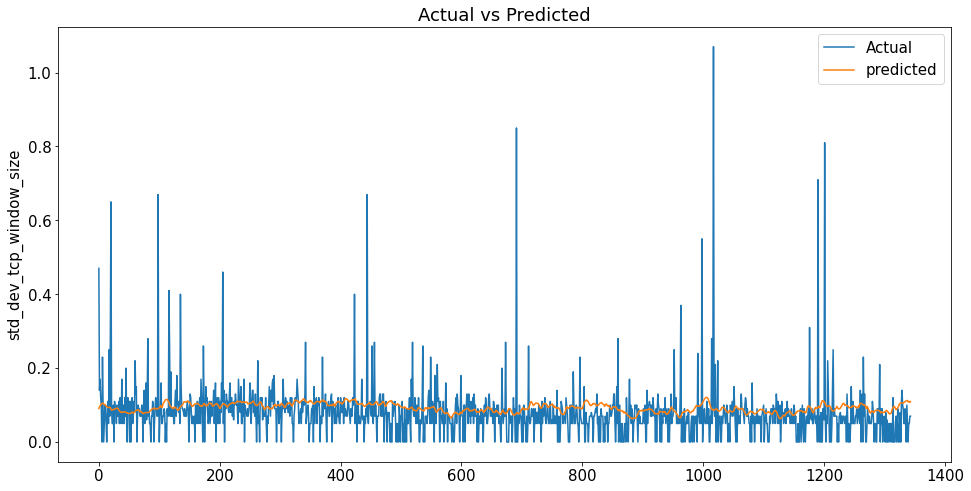


Day  3 :
MAE-E1D1 :  0.042209737,     MAE-E2D2 :  0.04359227
[0.14000002 0.17000002 0.12       ... 0.07000001 0.07000001 0.07000001]
[0.09303492 0.09405889 0.09745345 ... 0.10165235 0.10740776 0.10870729]
MSE-E1D1 :  0.0055994056, MSE-E2D2 :  0.0056964946
RMSE-E1D1 :  0.074829176,     NRMSE-E1D1 :  0.83079004,     RMSE-E2D2 :  0.07547513
MAPE-E1D1 :  inf,     MAPE-E2D2 :  inf
R2 is  :  -0.03941390316178284


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


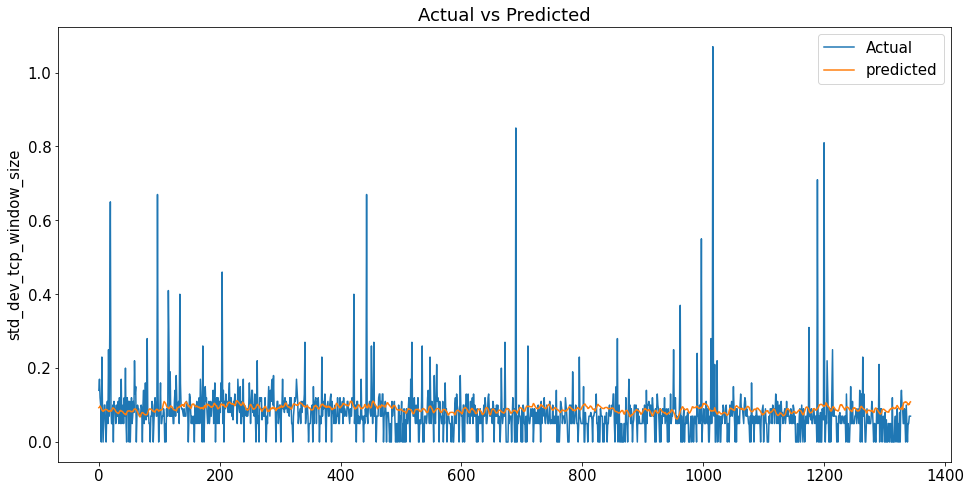

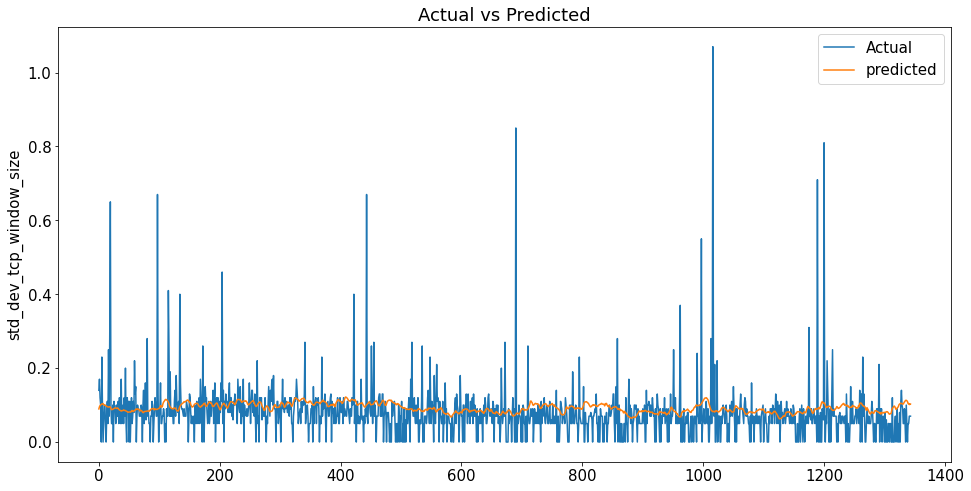


Day  4 :
MAE-E1D1 :  0.04198151,     MAE-E2D2 :  0.043340422
[0.17000002 0.12       0.10000001 ... 0.07000001 0.07000001 0.04999999]
[0.09512677 0.09614594 0.0980458  ... 0.1033413  0.1062118  0.10447571]
MSE-E1D1 :  0.0055745817, MSE-E2D2 :  0.0056917393
RMSE-E1D1 :  0.074663125,     NRMSE-E1D1 :  0.83707285,     RMSE-E2D2 :  0.07544362
MAPE-E1D1 :  inf,     MAPE-E2D2 :  inf
R2 is  :  -0.038959787910047616


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


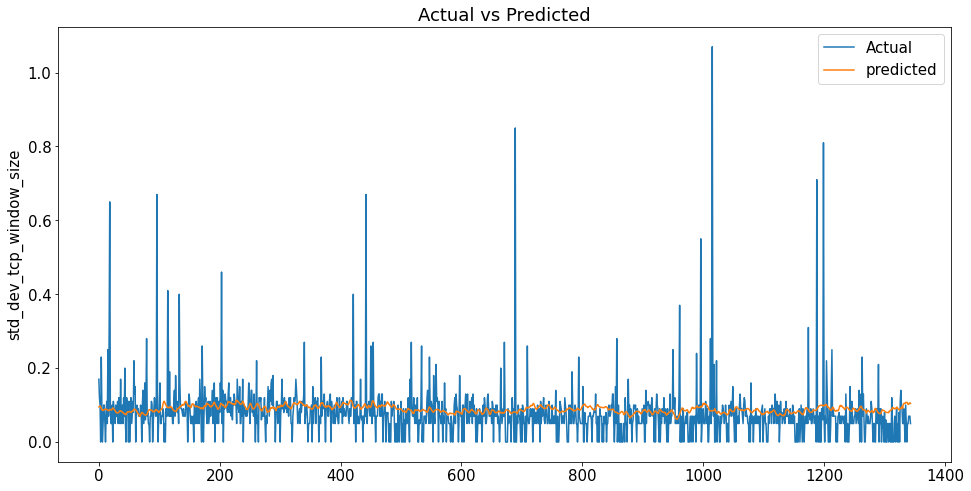

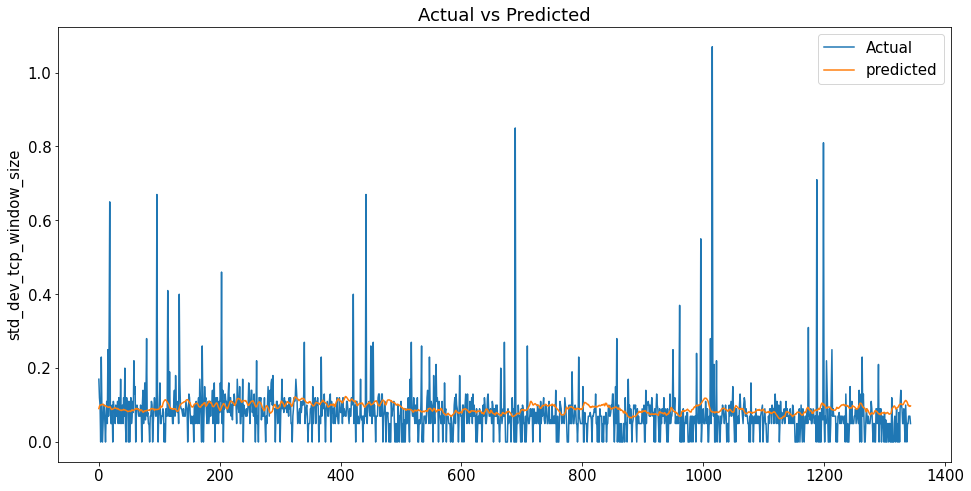


Day  5 :
MAE-E1D1 :  0.041709878,     MAE-E2D2 :  0.042921096
[0.12       0.10000001 0.         ... 0.07000001 0.04999999 0.10000001]
[0.09553183 0.09657627 0.09775412 ... 0.10378979 0.10517757 0.10194093]
MSE-E1D1 :  0.005544011, MSE-E2D2 :  0.0056625456
RMSE-E1D1 :  0.074458115,     NRMSE-E1D1 :  0.8399528,     RMSE-E2D2 :  0.07524989
MAPE-E1D1 :  inf,     MAPE-E2D2 :  inf
R2 is  :  -0.03473953638994565


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


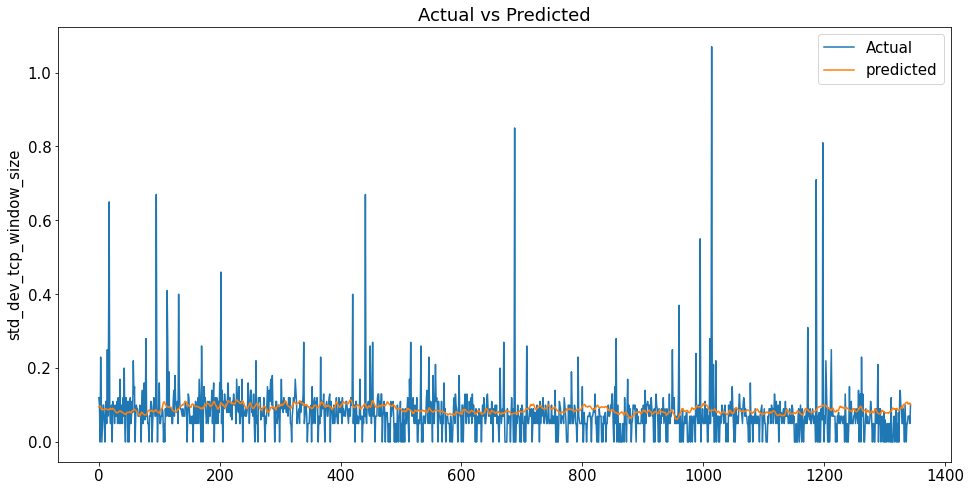

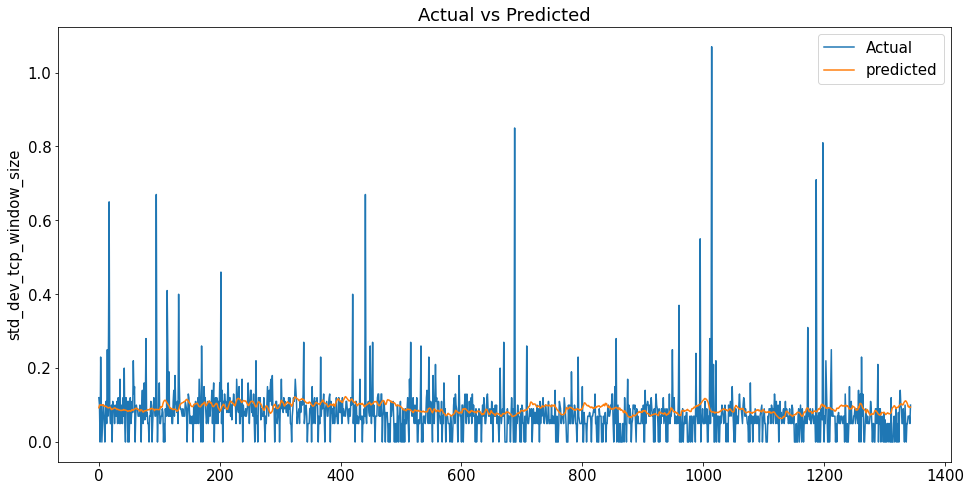



min_data_bytes

Day  1 :
MAE-E1D1 :  15.958824,     MAE-E2D2 :  15.891055
[ 99.        60.999996  63.       ...  80.        60.999996 102.00001 ]
[76.60845 75.85398 74.93787 ... 81.14192 82.02203 82.18829]
MSE-E1D1 :  418.14896, MSE-E2D2 :  413.52655
RMSE-E1D1 :  20.44869,     NRMSE-E1D1 :  0.2628389,     RMSE-E2D2 :  20.335352
MAPE-E1D1 :  20.23686170578003,     MAPE-E2D2 :  20.168641209602356
R2 is  :  -0.006399373351057003


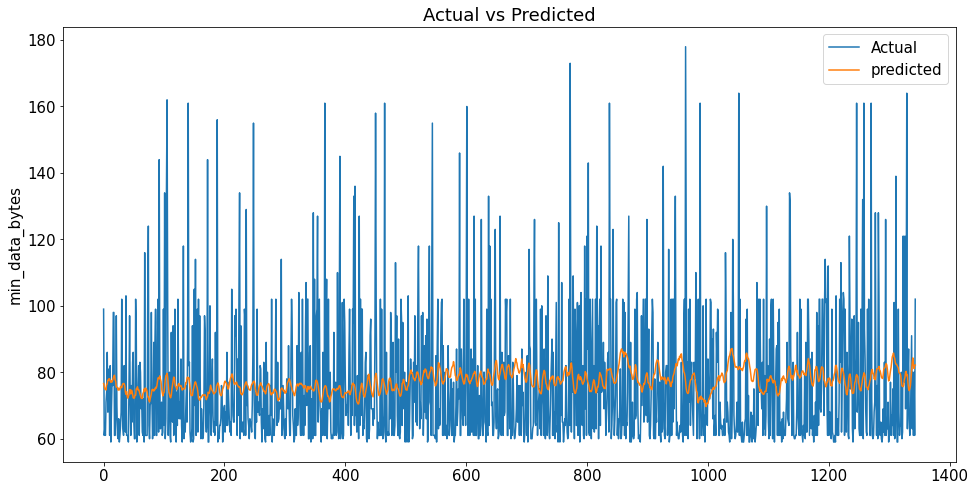

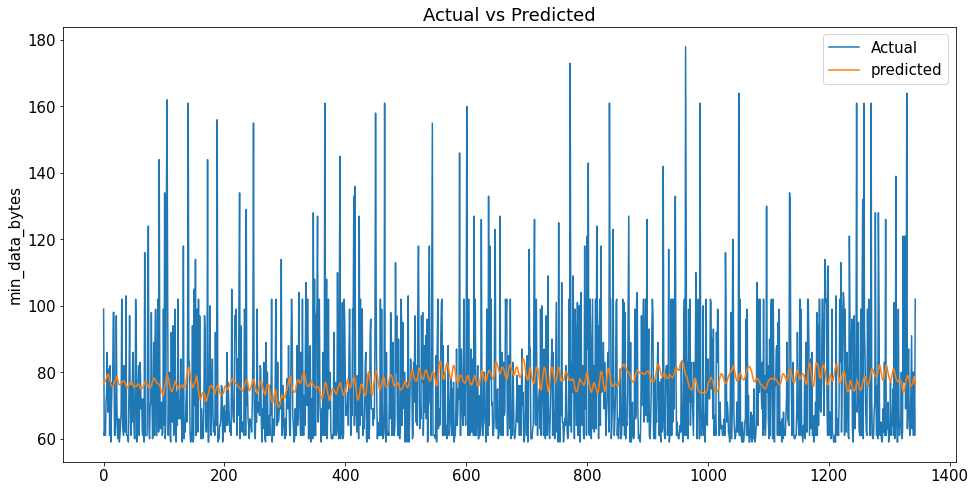


Day  2 :
MAE-E1D1 :  15.87169,     MAE-E2D2 :  15.924355
[ 60.999996  63.        60.999996 ...  60.999996 102.00001   71.      ]
[75.81216 75.09178 75.11714 ... 78.82795 79.75795 80.16651]
MSE-E1D1 :  416.5694, MSE-E2D2 :  415.228
RMSE-E1D1 :  20.410032,     NRMSE-E1D1 :  0.2633083,     RMSE-E2D2 :  20.377144
MAPE-E1D1 :  20.091083645820618,     MAPE-E2D2 :  20.2313169836998
R2 is  :  -0.01141127127588204


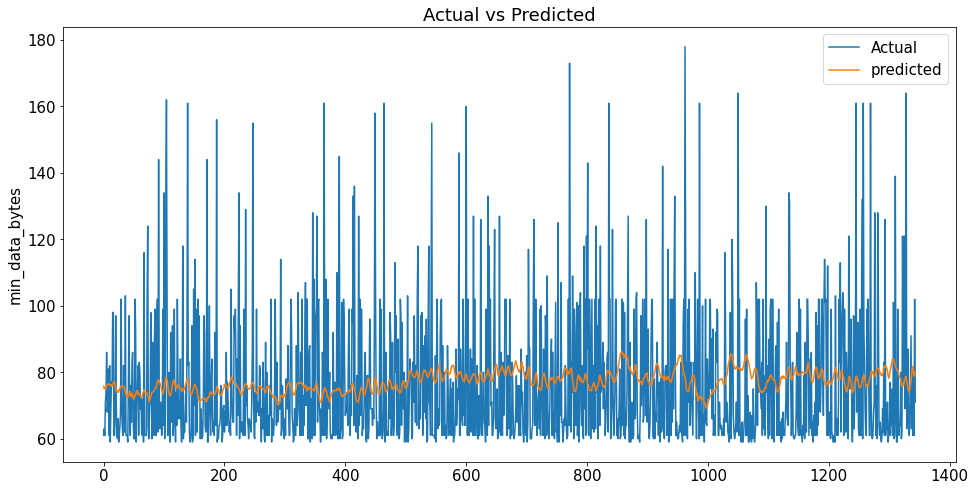

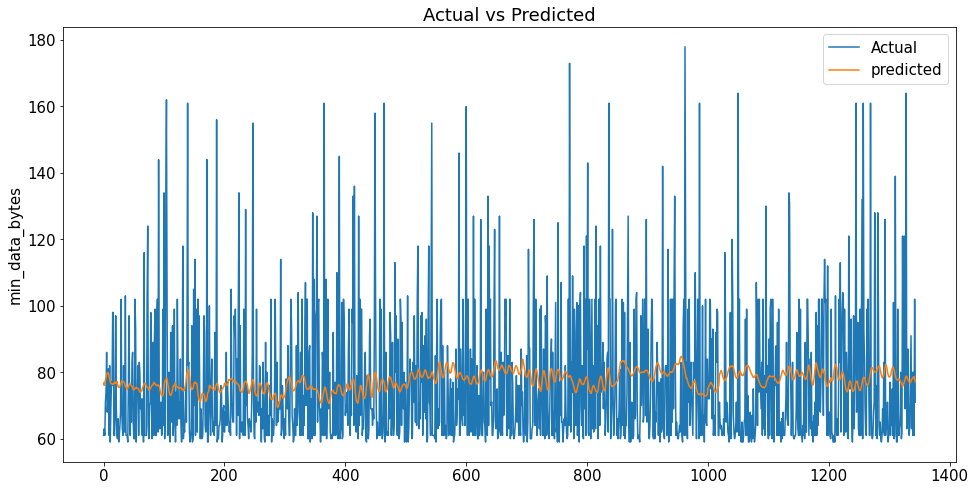


Day  3 :
MAE-E1D1 :  15.937342,     MAE-E2D2 :  16.017479
[ 63.        60.999996  71.       ... 102.00001   71.        60.999996]
[75.34565  74.733574 75.40328  ... 77.85757  79.05583  79.67593 ]
MSE-E1D1 :  417.37128, MSE-E2D2 :  416.8087
RMSE-E1D1 :  20.429667,     NRMSE-E1D1 :  0.26304546,     RMSE-E2D2 :  20.415894
MAPE-E1D1 :  20.231392979621887,     MAPE-E2D2 :  20.41463404893875
R2 is  :  -0.015261562139912588


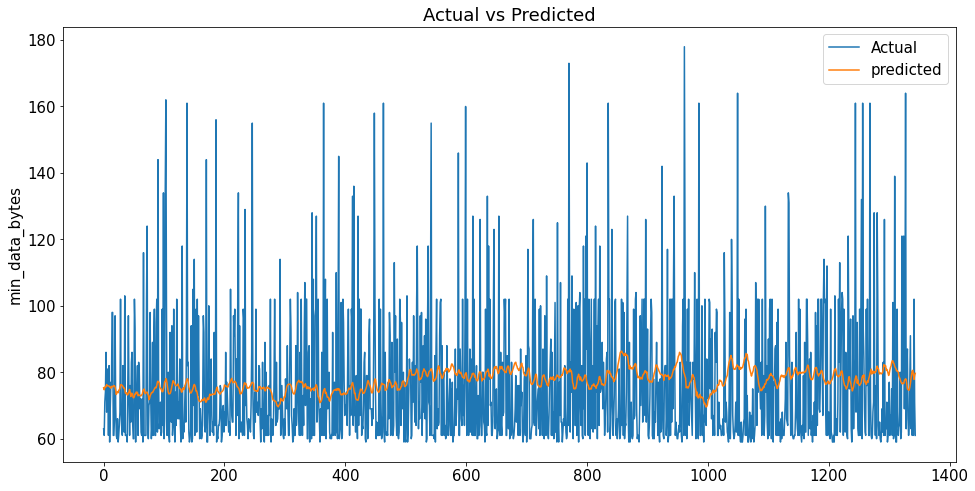

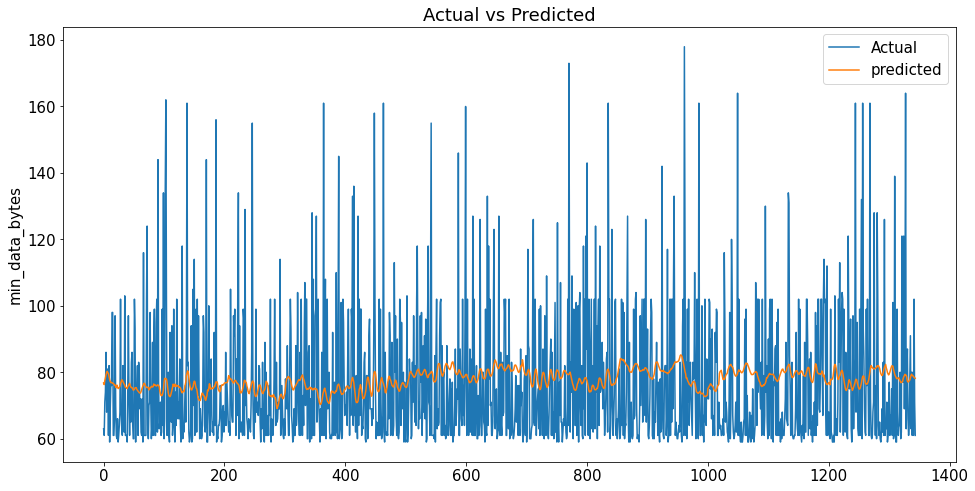


Day  4 :
MAE-E1D1 :  16.02968,     MAE-E2D2 :  16.094076
[60.999996 71.       74.       ... 71.       60.999996 67.      ]
[75.21151  74.72992  75.783554 ... 77.245316 78.69295  79.47158 ]
MSE-E1D1 :  418.16742, MSE-E2D2 :  417.70276
RMSE-E1D1 :  20.449142,     NRMSE-E1D1 :  0.26251417,     RMSE-E2D2 :  20.437778
MAPE-E1D1 :  20.432277023792267,     MAPE-E2D2 :  20.57424783706665
R2 is  :  -0.017608855061820305


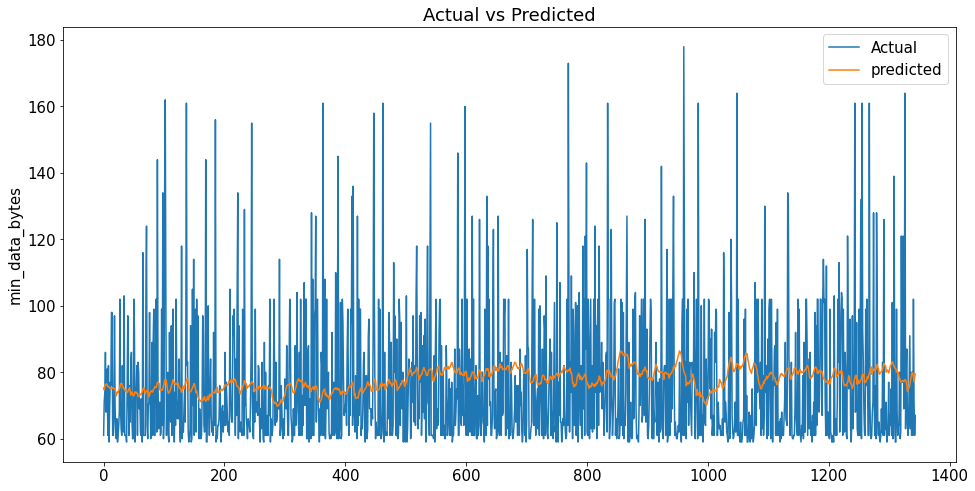

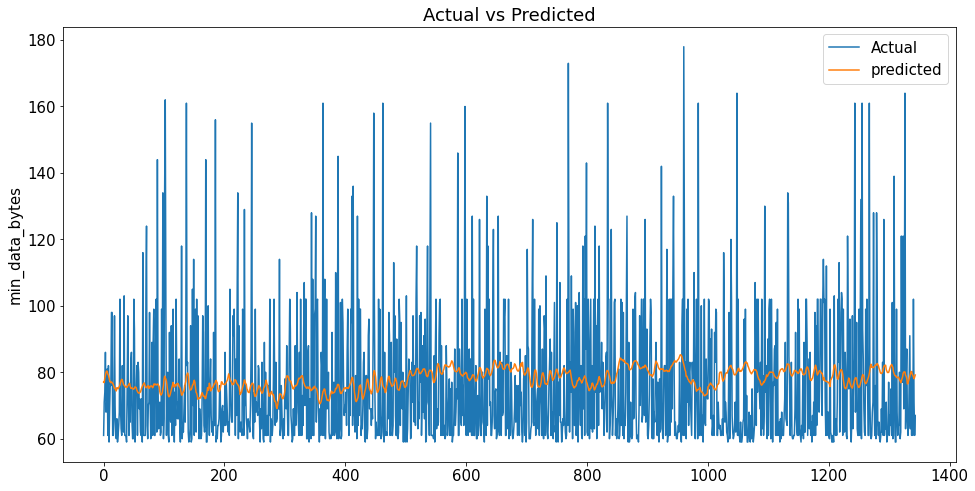


Day  5 :
MAE-E1D1 :  16.097134,     MAE-E2D2 :  16.150156
[71.       74.       86.       ... 60.999996 67.       87.      ]
[75.109474 74.74791  76.01228  ... 76.71643  78.36223  79.22871 ]
MSE-E1D1 :  419.6811, MSE-E2D2 :  418.451
RMSE-E1D1 :  20.48612,     NRMSE-E1D1 :  0.26220354,     RMSE-E2D2 :  20.456074
MAPE-E1D1 :  20.55104523897171,     MAPE-E2D2 :  20.68227082490921
R2 is  :  -0.019672832019260067


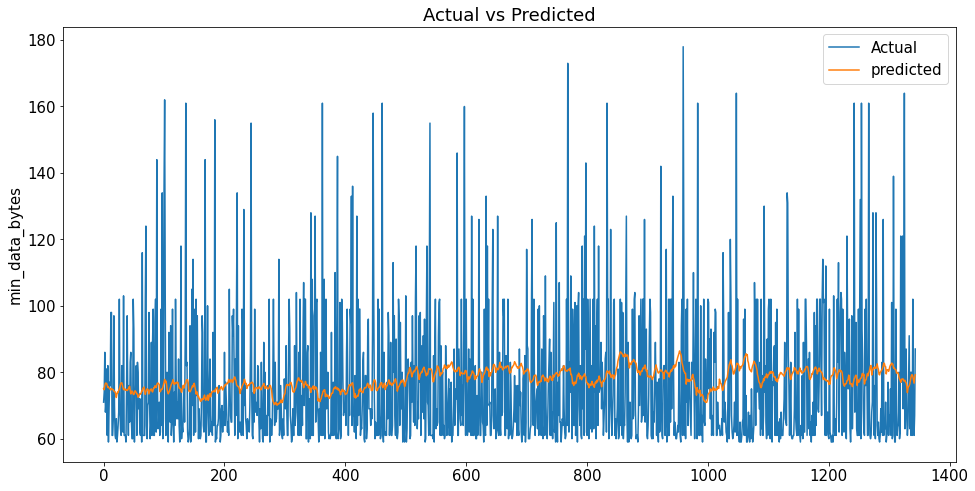

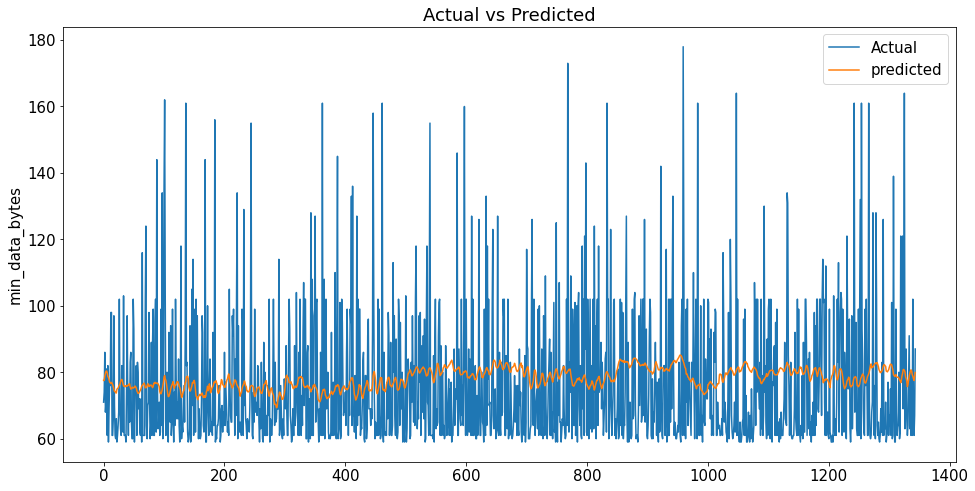



max_data_bytes

Day  1 :
MAE-E1D1 :  644.13086,     MAE-E2D2 :  645.3759
[11636.    10188.    13083.999 ... 11915.    11636.    11636.   ]
[11892.312 11896.304 11959.596 ... 11698.218 11671.251 11649.236]
MSE-E1D1 :  713334.0, MSE-E2D2 :  713655.1
RMSE-E1D1 :  844.591,     NRMSE-E1D1 :  0.07177624,     RMSE-E2D2 :  844.7811
MAPE-E1D1 :  5.496429279446602,     MAPE-E2D2 :  5.5038828402757645
R2 is  :  0.0014987185884213217


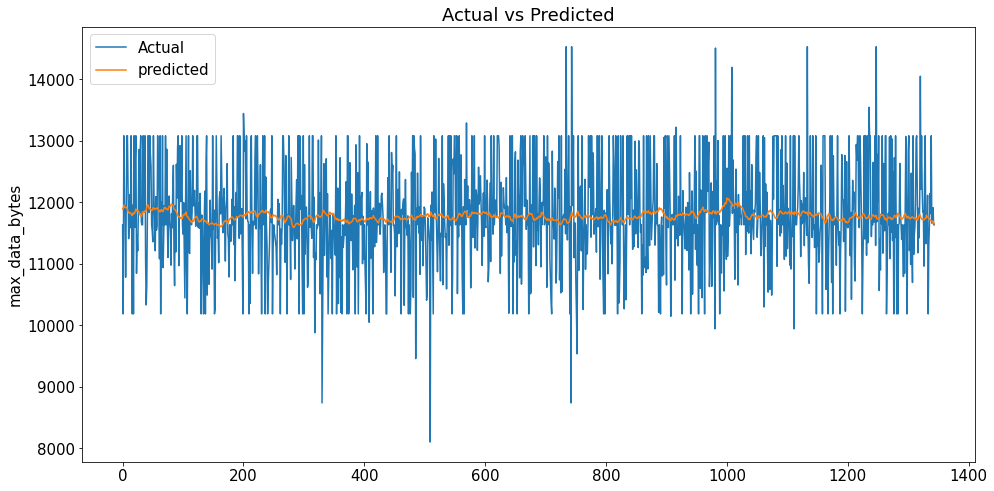

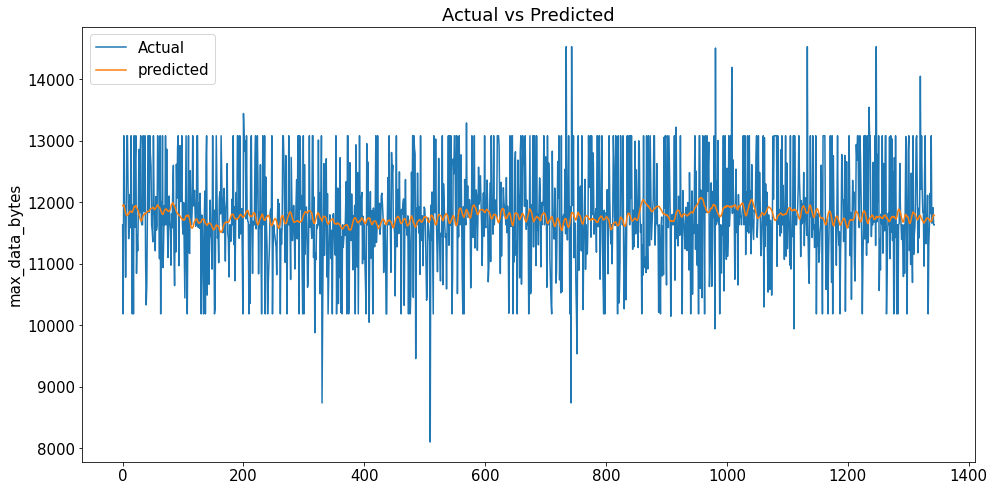


Day  2 :
MAE-E1D1 :  644.89856,     MAE-E2D2 :  646.9208
[10188.    13083.999 11915.    ... 11636.    11636.    12377.999]
[11896.116 11888.47  11945.644 ... 11750.561 11706.347 11676.428]
MSE-E1D1 :  712864.56, MSE-E2D2 :  715190.0
RMSE-E1D1 :  844.31305,     NRMSE-E1D1 :  0.071802415,     RMSE-E2D2 :  845.6891
MAPE-E1D1 :  5.505121499300003,     MAPE-E2D2 :  5.520372837781906
R2 is  :  -0.0003351818513552818


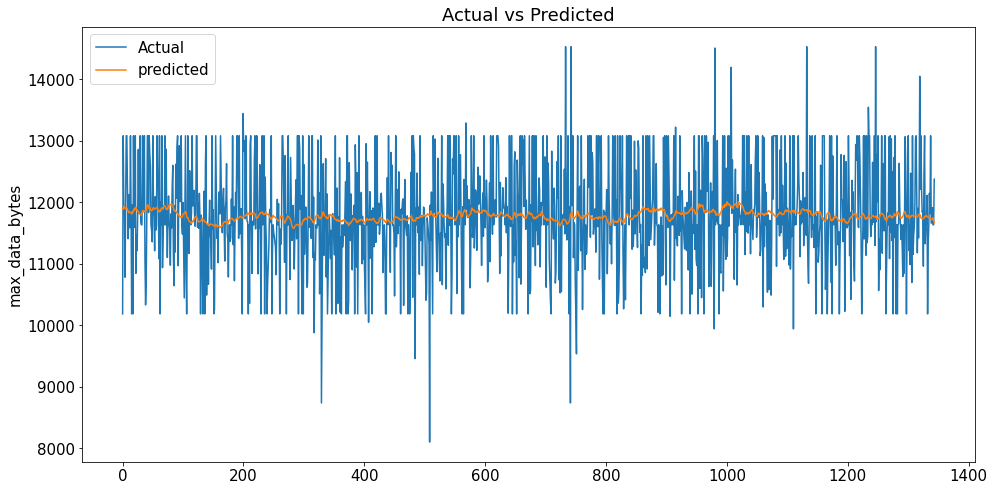

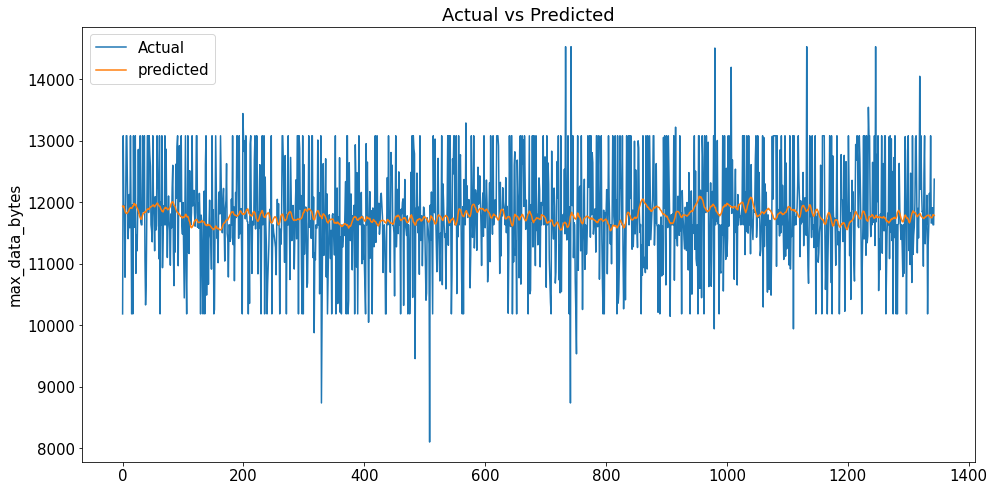


Day  3 :
MAE-E1D1 :  644.5935,     MAE-E2D2 :  645.8999
[13083.999 11915.    11949.    ... 11636.    12377.999 11929.   ]
[11902.189 11889.054 11943.44  ... 11780.139 11719.516 11679.755]
MSE-E1D1 :  709968.9, MSE-E2D2 :  711948.3
RMSE-E1D1 :  842.5965,     NRMSE-E1D1 :  0.07157722,     RMSE-E2D2 :  843.7703
MAPE-E1D1 :  5.504836514592171,     MAPE-E2D2 :  5.514692515134811
R2 is  :  0.0014982899541997607


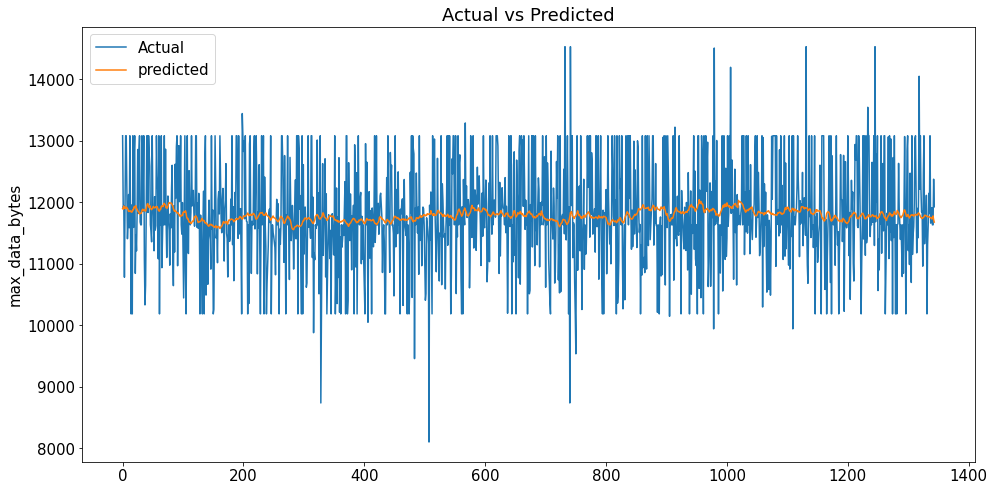

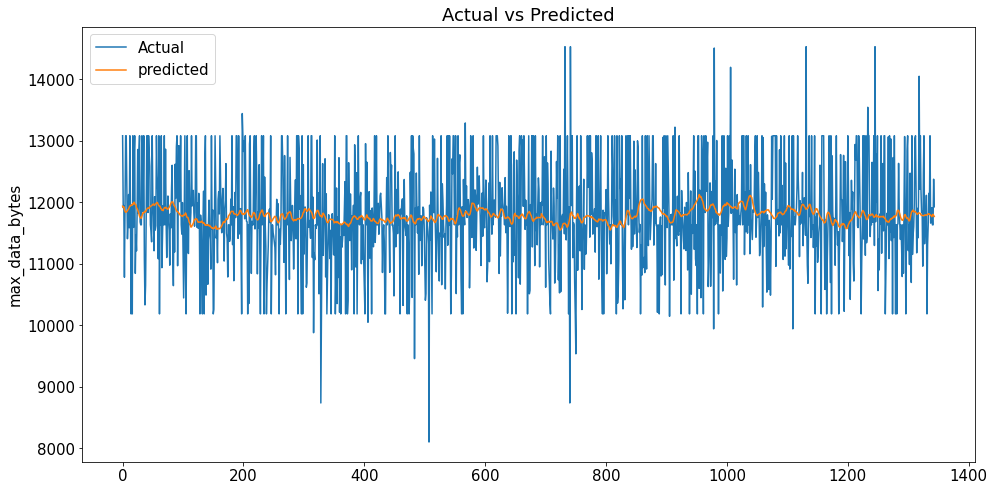


Day  4 :
MAE-E1D1 :  645.1184,     MAE-E2D2 :  645.8029
[11915.    11949.    10784.    ... 12377.999 11929.    12036.   ]
[11904.288  11888.129  11940.3125 ... 11795.207  11724.583  11679.62  ]
MSE-E1D1 :  709033.44, MSE-E2D2 :  710204.9
RMSE-E1D1 :  842.04126,     NRMSE-E1D1 :  0.07141379,     RMSE-E2D2 :  842.7365
MAPE-E1D1 :  5.513235926628113,     MAPE-E2D2 :  5.520332604646683
R2 is  :  0.0022961820461356863


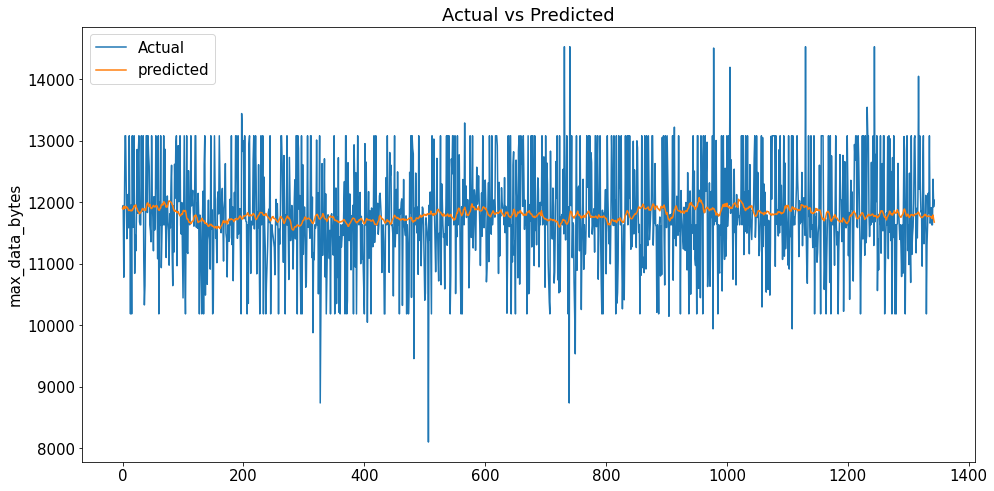

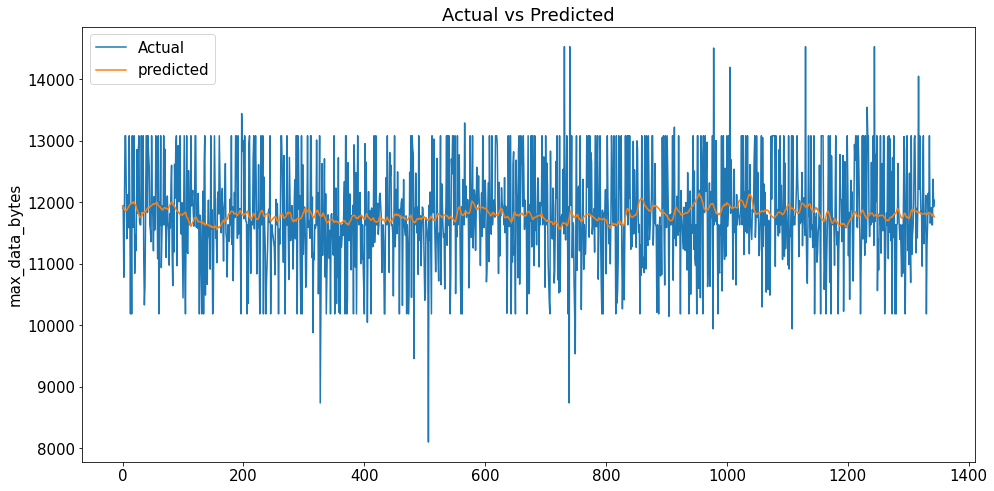


Day  5 :
MAE-E1D1 :  645.4372,     MAE-E2D2 :  646.84753
[11949.    10784.    11887.    ... 11929.    12036.    13083.999]
[11902.9   11884.982 11935.689 ... 11800.185 11724.869 11678.75 ]
MSE-E1D1 :  709064.25, MSE-E2D2 :  710321.9
RMSE-E1D1 :  842.0595,     NRMSE-E1D1 :  0.07134603,     RMSE-E2D2 :  842.80597
MAPE-E1D1 :  5.5170610547065735,     MAPE-E2D2 :  5.534261092543602
R2 is  :  0.0038219940266621677


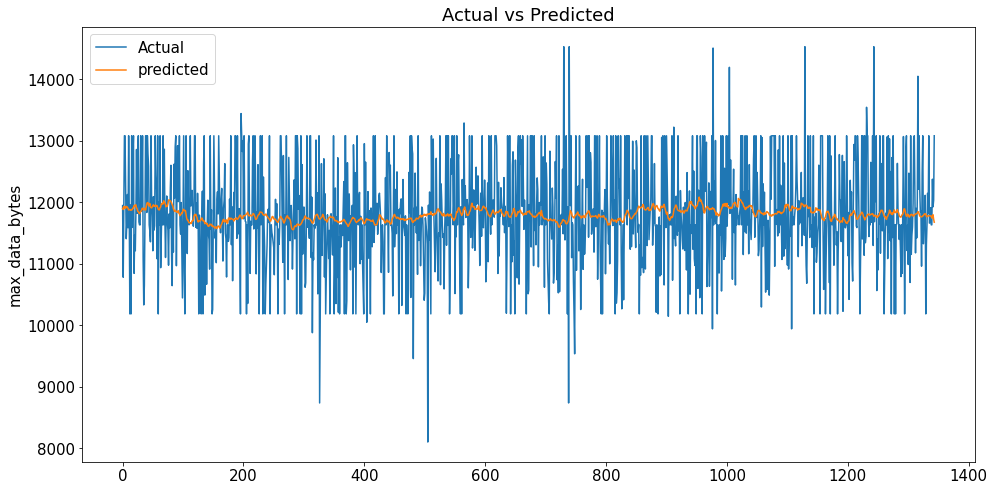

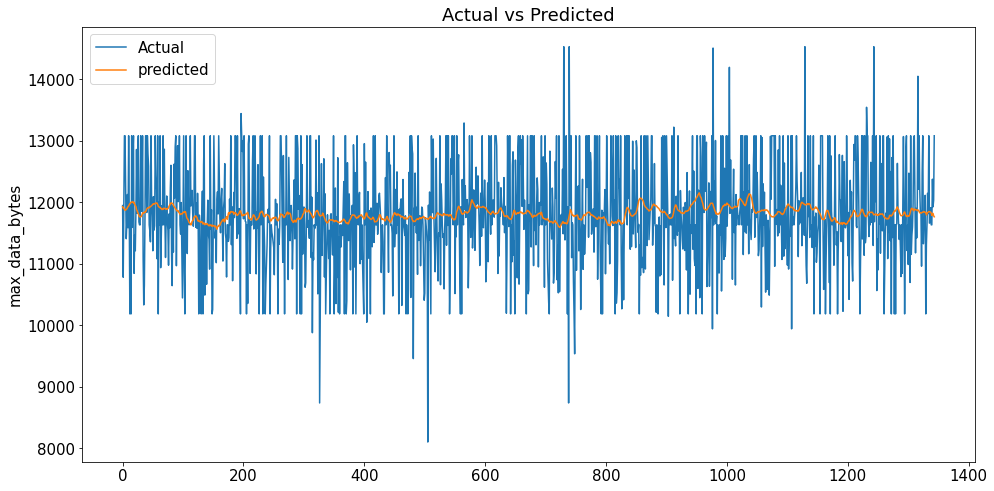



avg_databytes

Day  1 :
MAE-E1D1 :  3.9396718,     MAE-E2D2 :  4.2687354
[2237.4834 2235.7441 2244.1106 ... 2186.0325 2175.4727 2180.122 ]
[2230.8857 2233.5178 2236.6091 ... 2197.1594 2186.8477 2177.3464]
MSE-E1D1 :  24.02801, MSE-E2D2 :  28.545626
RMSE-E1D1 :  4.9018373,     NRMSE-E1D1 :  0.0023995524,     RMSE-E2D2 :  5.3428106
MAPE-E1D1 :  0.1767917536199093,     MAPE-E2D2 :  0.1914636348374188
R2 is  :  0.9686644579932528


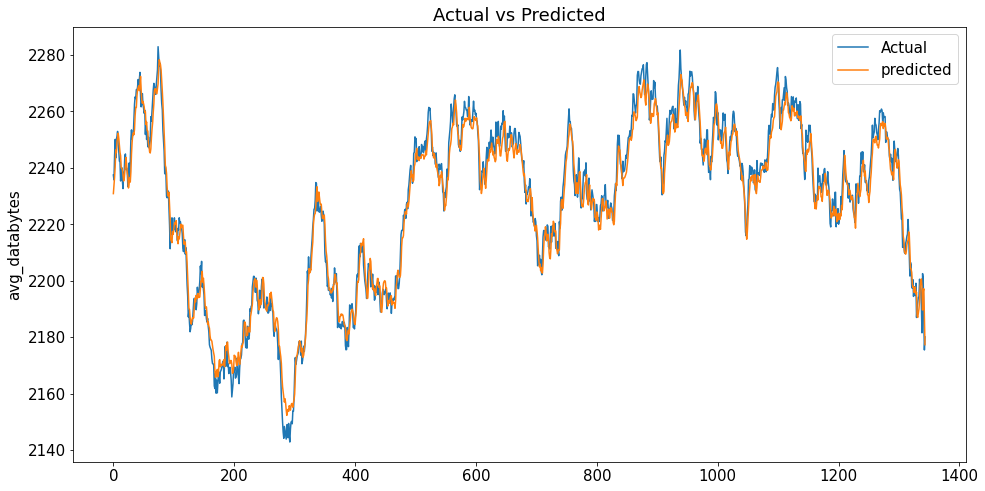

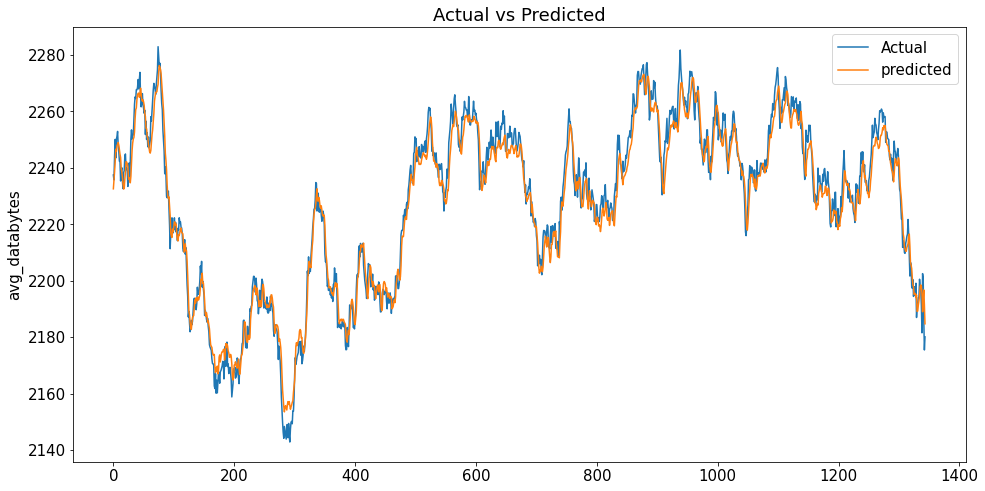


Day  2 :
MAE-E1D1 :  5.0142503,     MAE-E2D2 :  5.636172
[2235.7441 2244.1106 2250.0964 ... 2175.4727 2180.122  2194.0144]
[2230.6855 2233.9338 2237.3694 ... 2195.442  2183.889  2173.9934]
MSE-E1D1 :  39.185364, MSE-E2D2 :  48.274883
RMSE-E1D1 :  6.2598214,     NRMSE-E1D1 :  0.0031215705,     RMSE-E2D2 :  6.948013
MAPE-E1D1 :  0.22485647350549698,     MAPE-E2D2 :  0.25260213296860456
R2 is  :  0.9470539585107363


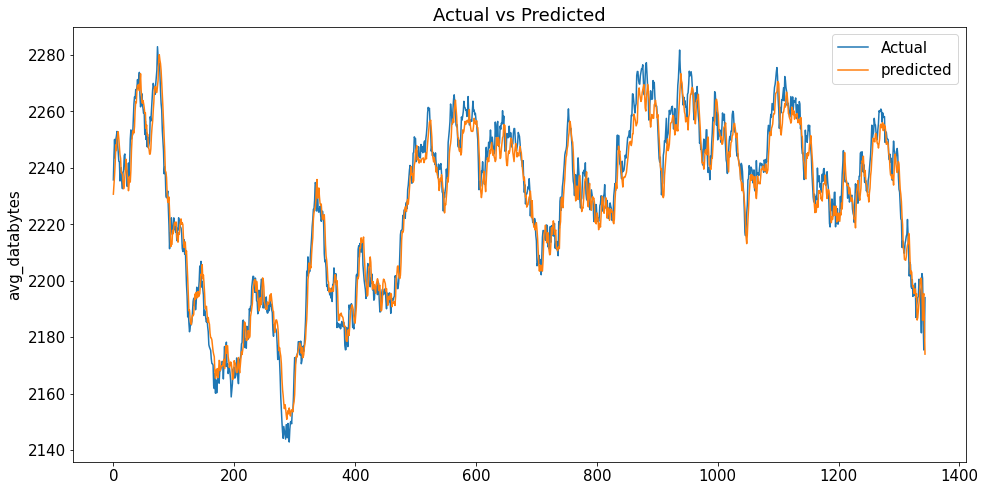

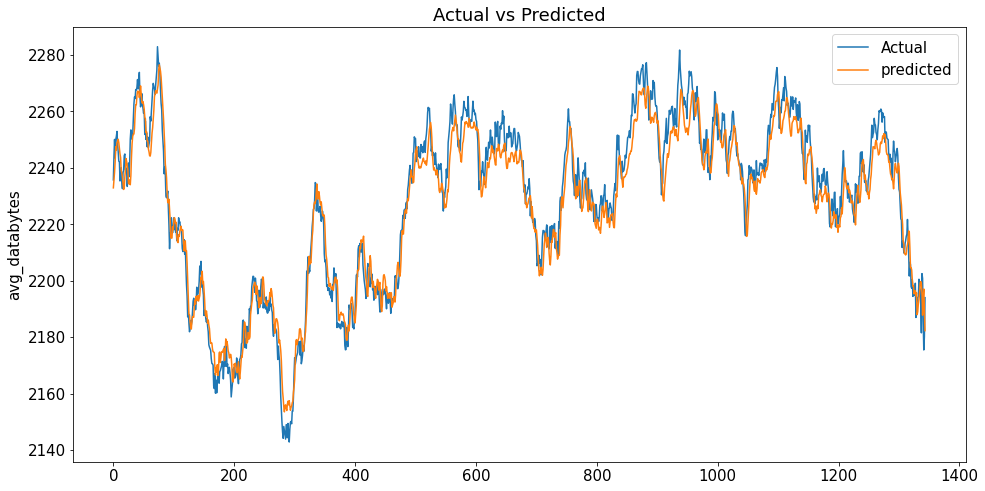


Day  3 :
MAE-E1D1 :  6.2309365,     MAE-E2D2 :  6.9923496
[2244.1106 2250.0964 2243.5166 ... 2180.122  2194.0144 2192.4438]
[2230.4377 2233.9834 2237.552  ... 2194.3591 2182.0217 2172.0637]
MSE-E1D1 :  59.257057, MSE-E2D2 :  73.30957
RMSE-E1D1 :  7.6978607,     NRMSE-E1D1 :  0.0038478184,     RMSE-E2D2 :  8.5621
MAPE-E1D1 :  0.2793045714497566,     MAPE-E2D2 :  0.31326115131378174
R2 is  :  0.9196770644404976


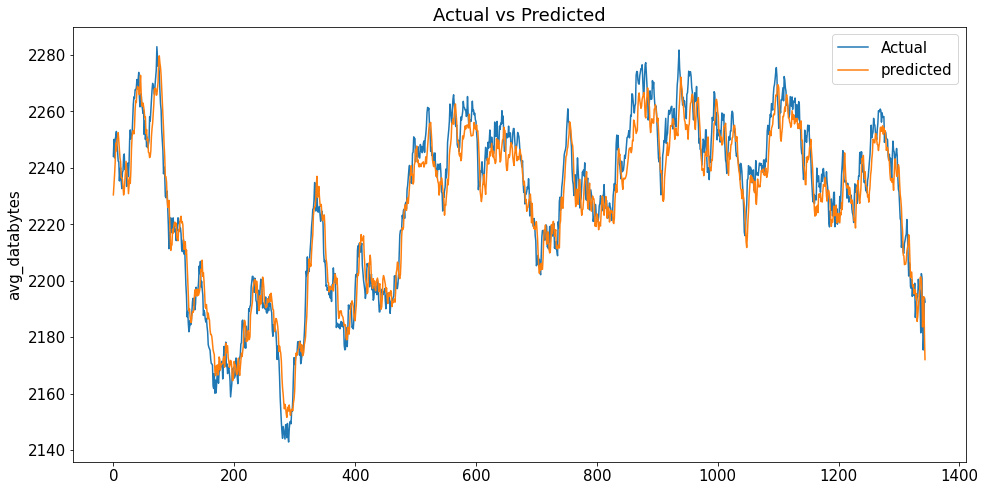

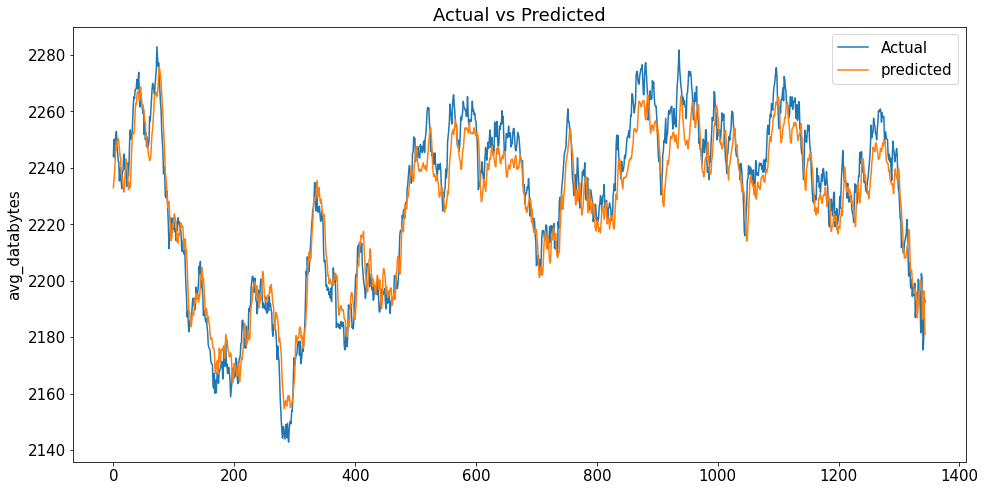


Day  4 :
MAE-E1D1 :  7.380045,     MAE-E2D2 :  8.315275
[2250.0964 2243.5166 2250.07   ... 2194.0144 2192.4438 2161.3943]
[2230.2114 2233.892  2237.4915 ... 2193.5942 2180.8376 2171.0234]
MSE-E1D1 :  81.950874, MSE-E2D2 :  102.6436
RMSE-E1D1 :  9.052672,     NRMSE-E1D1 :  0.0045542284,     RMSE-E2D2 :  10.131318
MAPE-E1D1 :  0.3307251026853919,     MAPE-E2D2 :  0.3724886570125818
R2 is  :  0.8879209741317305


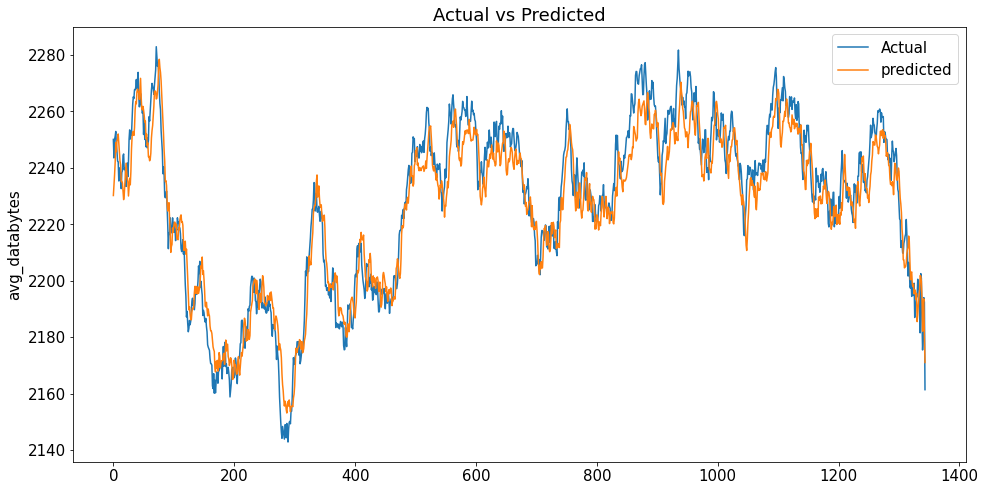

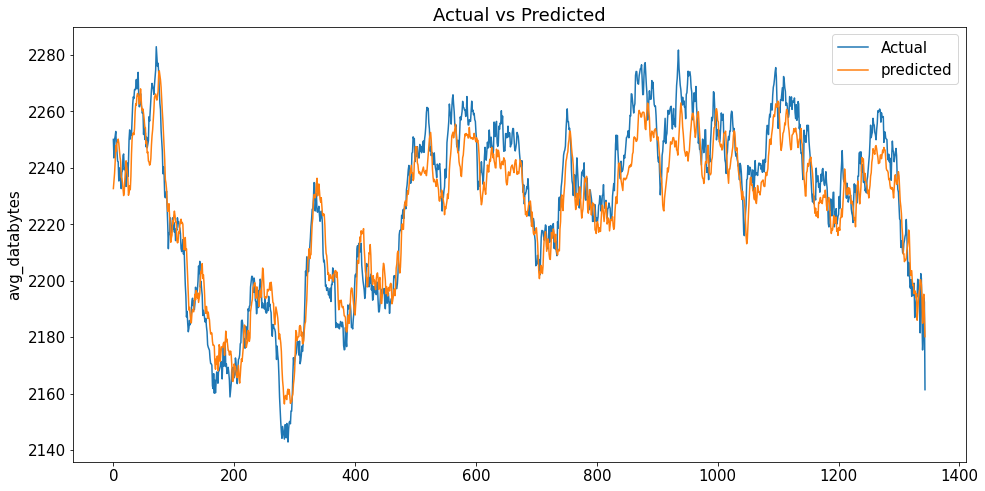


Day  5 :
MAE-E1D1 :  8.440907,     MAE-E2D2 :  9.582235
[2243.5166 2250.07   2251.2158 ... 2192.4438 2161.3943 2157.2983]
[2229.991  2233.7253 2237.3152 ... 2192.9722 2179.986  2170.3723]
MSE-E1D1 :  106.779335, MSE-E2D2 :  135.95697
RMSE-E1D1 :  10.333408,     NRMSE-E1D1 :  0.0052428506,     RMSE-E2D2 :  11.660059
MAPE-E1D1 :  0.37823759485036135,     MAPE-E2D2 :  0.42924024164676666
R2 is  :  0.8520897397059826


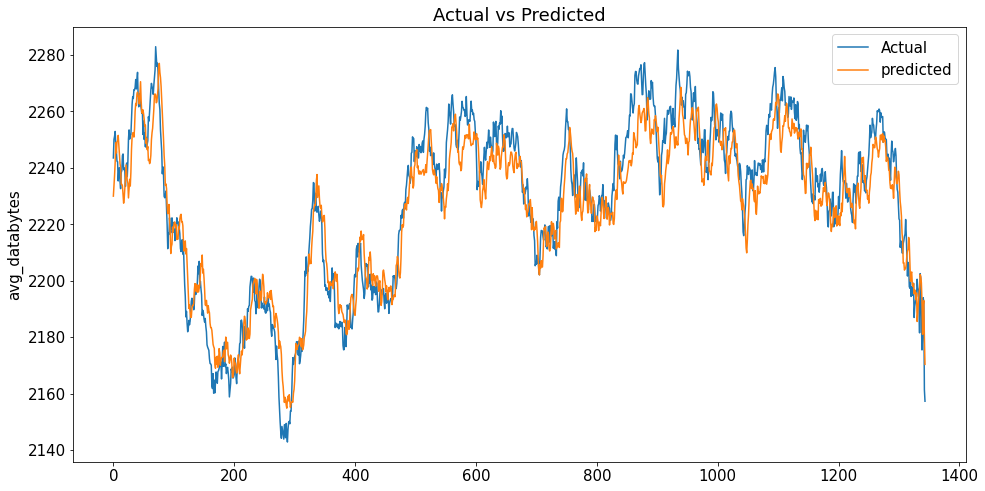

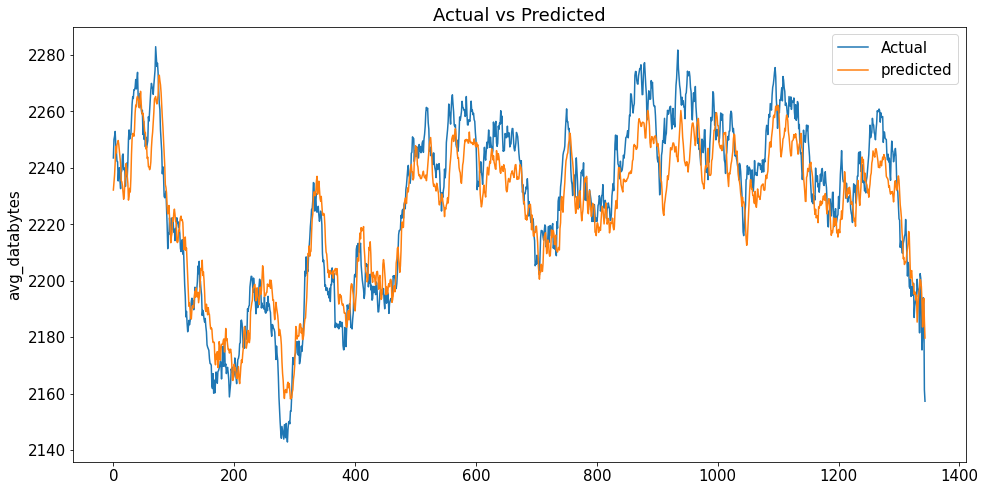



std_dev_databytes

Day  1 :
MAE-E1D1 :  4.456229,     MAE-E2D2 :  5.2125688
[2249.509  2249.692  2262.0432 ... 2201.1875 2188.7417 2190.912 ]
[2243.513  2246.277  2250.0967 ... 2217.5347 2205.6914 2195.9133]
MSE-E1D1 :  31.71546, MSE-E2D2 :  44.54543
RMSE-E1D1 :  5.631648,     NRMSE-E1D1 :  0.0030040673,     RMSE-E2D2 :  6.6742363
MAPE-E1D1 :  0.2001771703362465,     MAPE-E2D2 :  0.23372876457870007
R2 is  :  0.9442313857199015


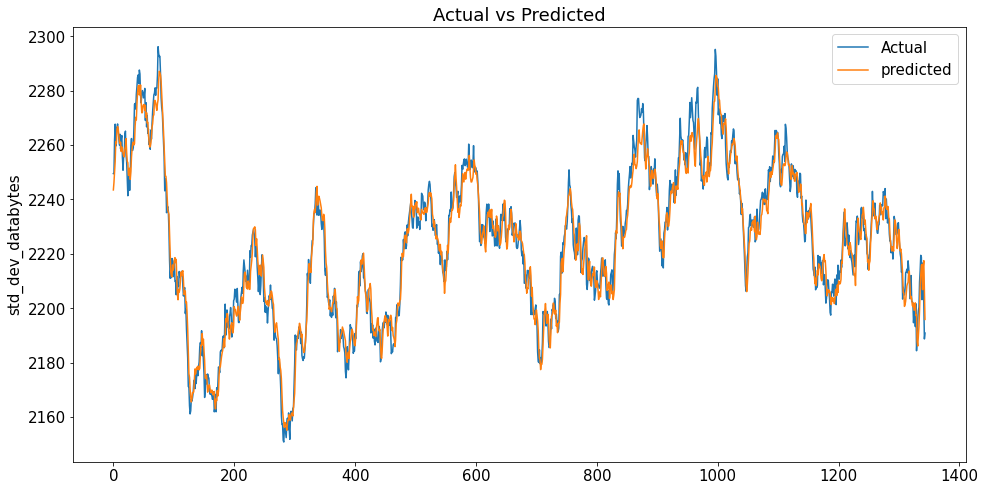

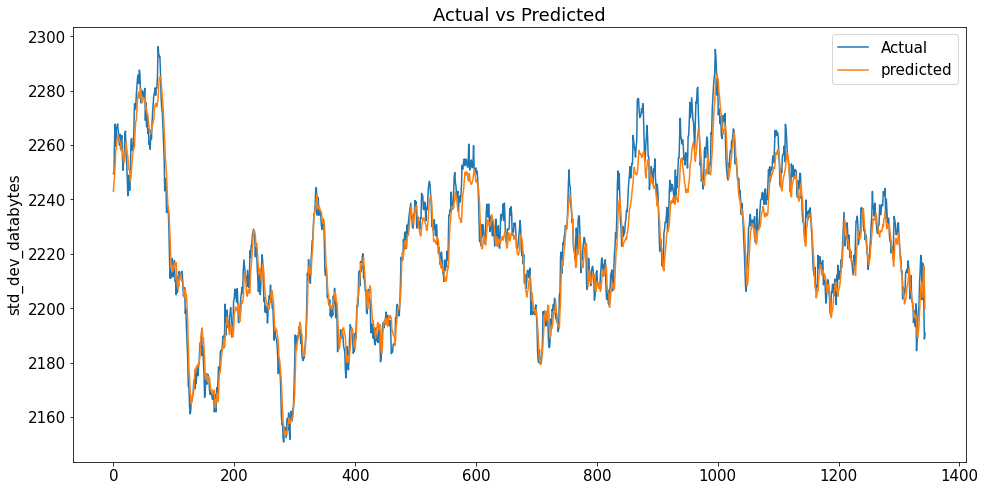


Day  2 :
MAE-E1D1 :  5.7758713,     MAE-E2D2 :  6.4491005
[2249.692  2262.0432 2267.6934 ... 2188.7417 2190.912  2209.0012]
[2243.5896 2246.747  2250.945  ... 2216.52   2203.4453 2192.9634]
MSE-E1D1 :  53.559547, MSE-E2D2 :  67.32754
RMSE-E1D1 :  7.318439,     NRMSE-E1D1 :  0.00369388,     RMSE-E2D2 :  8.205336
MAPE-E1D1 :  0.2593532204627991,     MAPE-E2D2 :  0.28924504294991493
R2 is  :  0.91567629658722


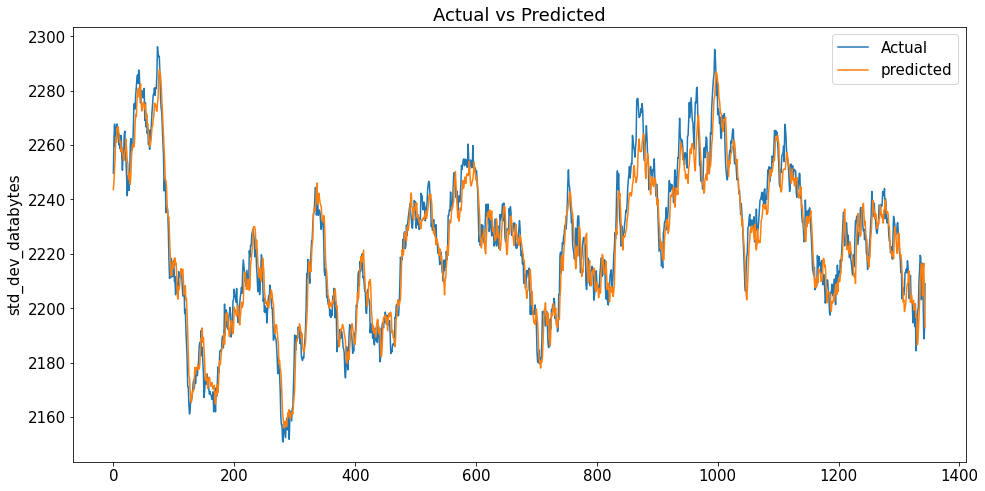

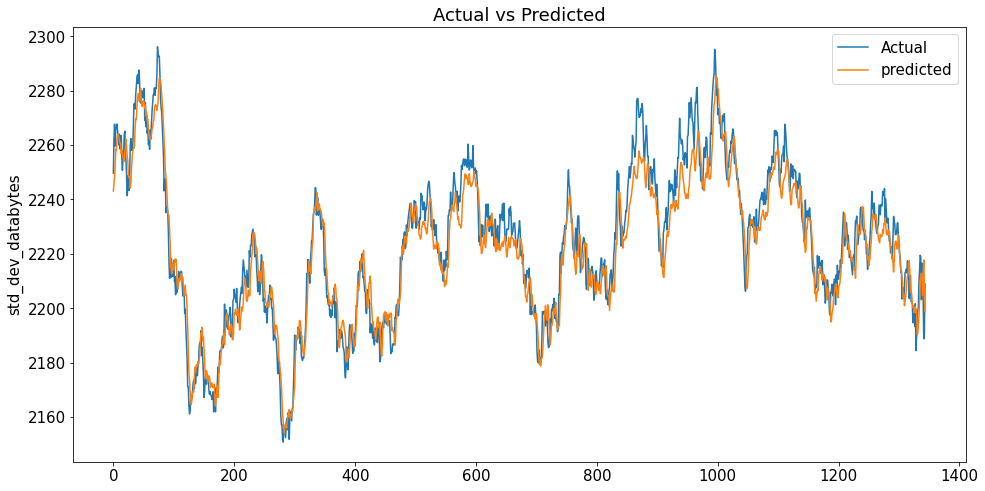


Day  3 :
MAE-E1D1 :  7.0545087,     MAE-E2D2 :  7.771118
[2262.0432 2267.6934 2259.6292 ... 2190.912  2209.0012 2208.5312]
[2243.4414 2246.8484 2251.207  ... 2215.6406 2201.9326 2191.2708]
MSE-E1D1 :  79.46784, MSE-E2D2 :  96.99288
RMSE-E1D1 :  8.914474,     NRMSE-E1D1 :  0.0044344296,     RMSE-E2D2 :  9.848496
MAPE-E1D1 :  0.31665151473134756,     MAPE-E2D2 :  0.34856852144002914
R2 is  :  0.8784748823689186


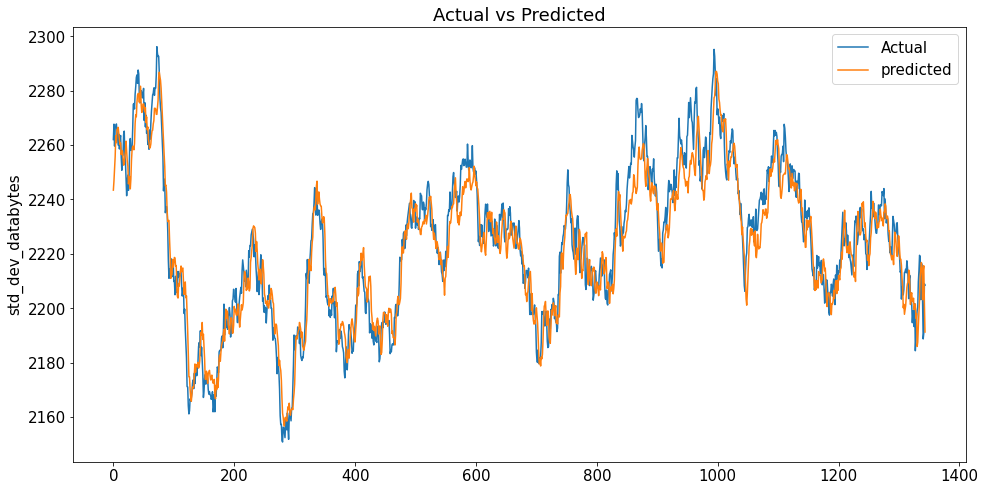

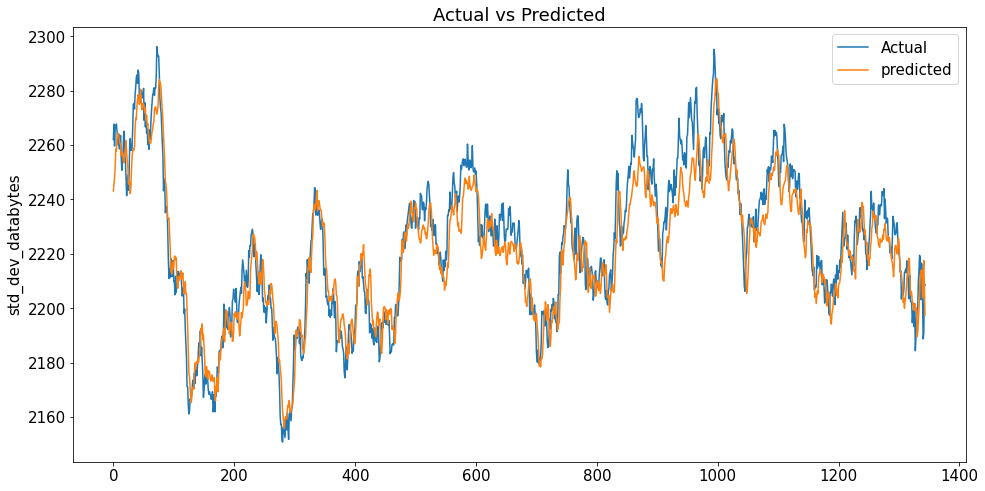


Day  4 :
MAE-E1D1 :  8.27741,     MAE-E2D2 :  9.151942
[2267.6934 2259.6292 2266.241  ... 2209.0012 2208.5312 2189.703 ]
[2243.0908 2246.651  2251.0637 ... 2214.638  2200.6982 2190.1565]
MSE-E1D1 :  107.22609, MSE-E2D2 :  130.78267
RMSE-E1D1 :  10.355003,     NRMSE-E1D1 :  0.0051503023,     RMSE-E2D2 :  11.436025
MAPE-E1D1 :  0.371522712521255,     MAPE-E2D2 :  0.41058133356273174
R2 is  :  0.8360971047773347


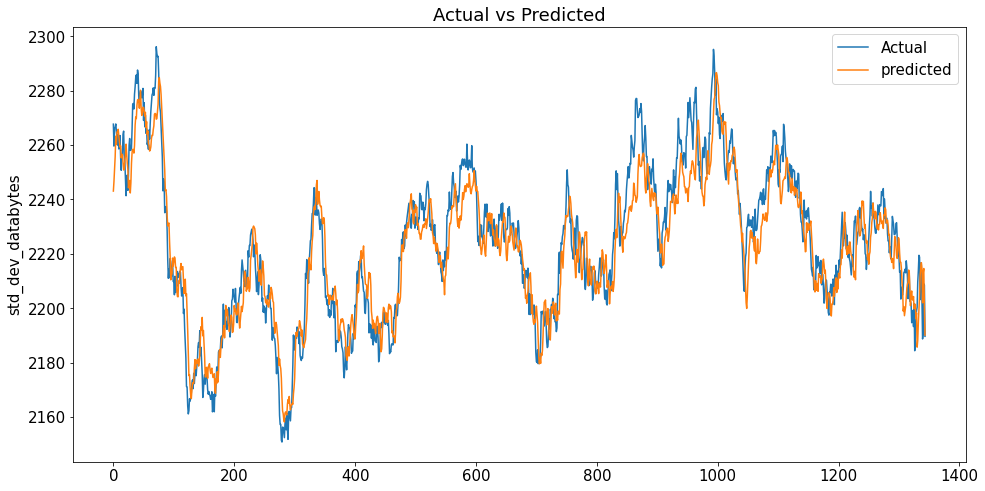

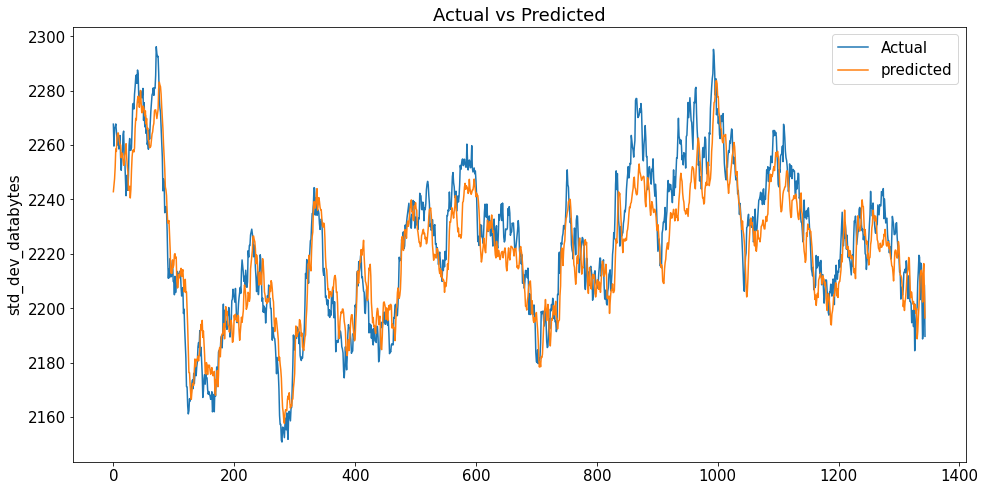


Day  5 :
MAE-E1D1 :  9.340899,     MAE-E2D2 :  10.441153
[2259.6292 2266.241  2266.6184 ... 2208.5312 2189.703  2199.9583]
[2242.6865 2246.343  2250.7708 ... 2213.6423 2199.6572 2189.3308]
MSE-E1D1 :  135.2841, MSE-E2D2 :  167.55225
RMSE-E1D1 :  11.631169,     NRMSE-E1D1 :  0.0058308565,     RMSE-E2D2 :  12.944198
MAPE-E1D1 :  0.41927057318389416,     MAPE-E2D2 :  0.4684592131525278
R2 is  :  0.7897531728234164


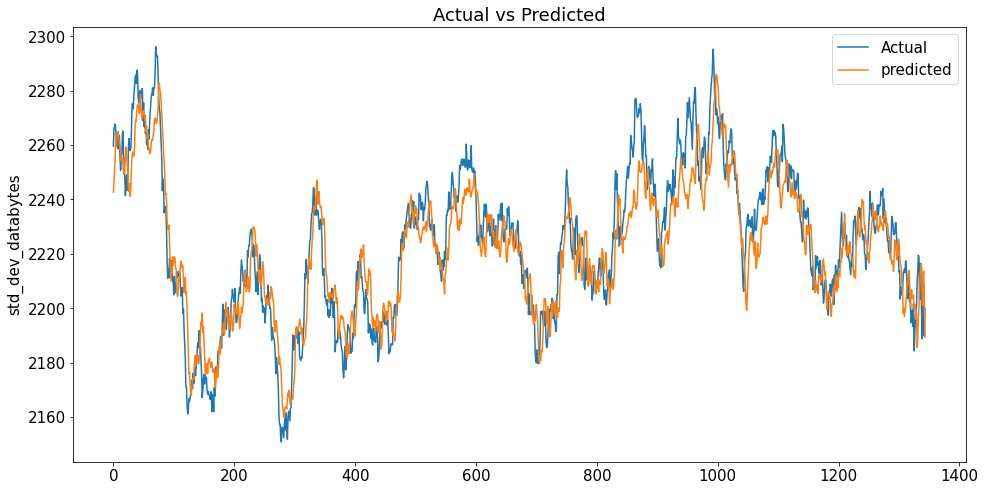

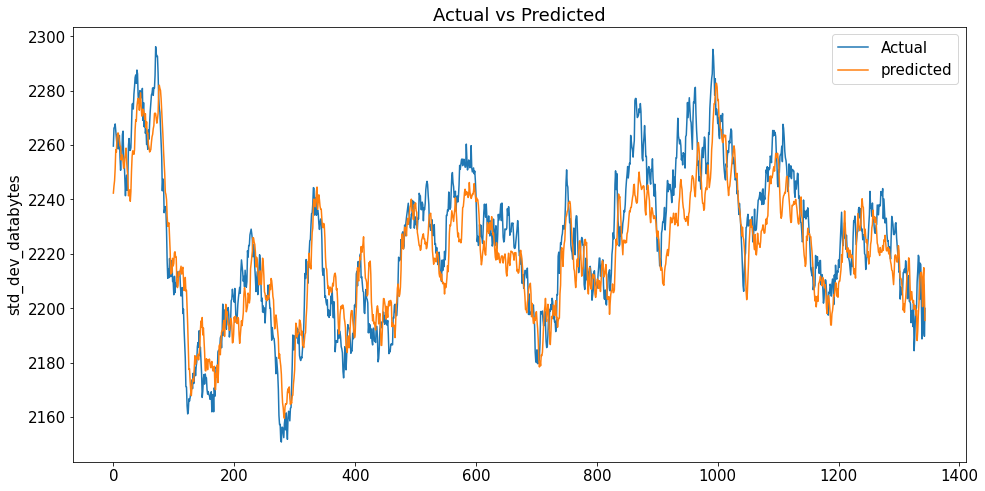



total_data_bytes

Day  1 :
MAE-E1D1 :  2728.7407,     MAE-E2D2 :  2733.9453
[847451.75 847575.56 847073.7  ... 886246.25 886865.4  886560.4 ]
[849694.5  849383.4  848909.94 ... 865801.6  868567.6  868980.06]
MSE-E1D1 :  12435074.0, MSE-E2D2 :  12757710.0
RMSE-E1D1 :  3526.34,     NRMSE-E1D1 :  0.004180235,     RMSE-E2D2 :  3571.7937
MAPE-E1D1 :  0.31966480892151594,     MAPE-E2D2 :  0.3200976178050041
R2 is  :  0.43548830959136353


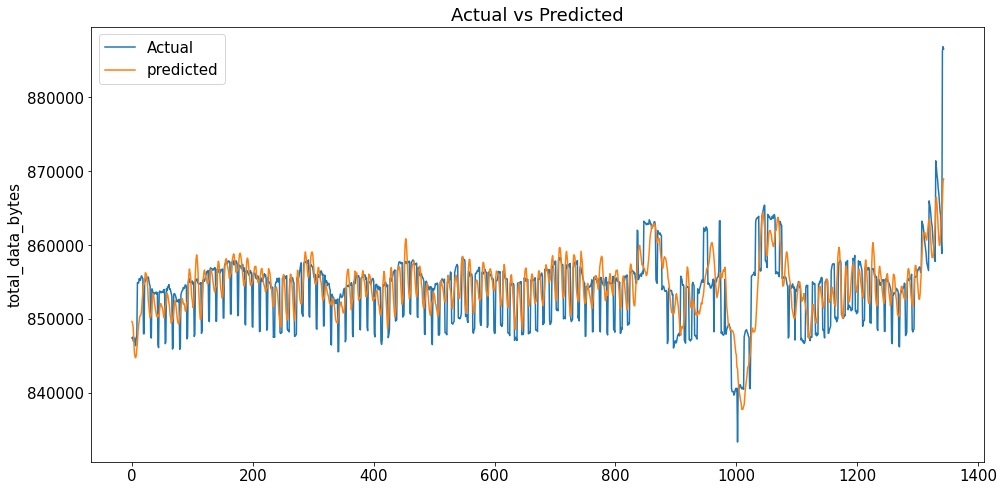

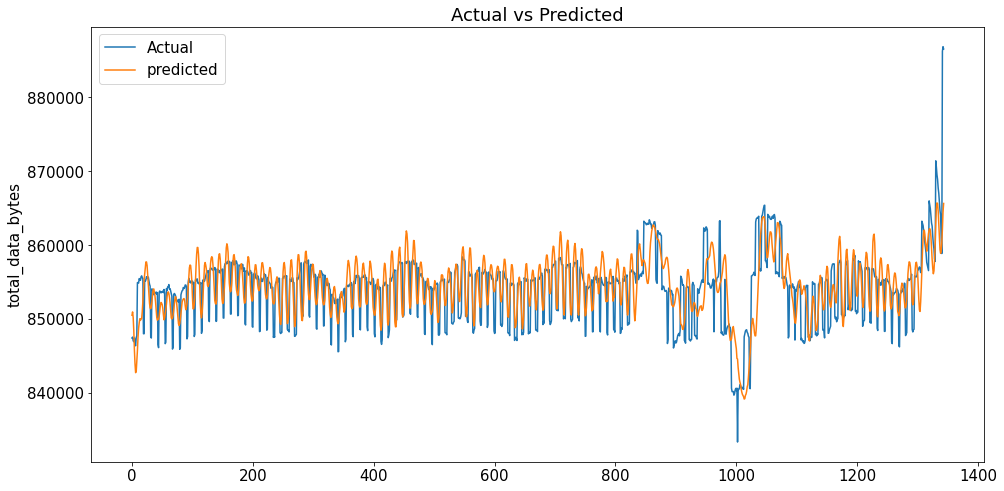


Day  2 :
MAE-E1D1 :  2685.8215,     MAE-E2D2 :  2658.7463
[847575.56 847073.7  846956.75 ... 886865.4  886560.4  886194.44]
[849565.94 849128.56 848560.75 ... 866058.5  868144.3  868319.9 ]
MSE-E1D1 :  12533989.0, MSE-E2D2 :  12666776.0
RMSE-E1D1 :  3540.3374,     NRMSE-E1D1 :  0.0041643865,     RMSE-E2D2 :  3559.0415
MAPE-E1D1 :  0.3145545022562146,     MAPE-E2D2 :  0.31140048522502184
R2 is  :  0.45701200340331816


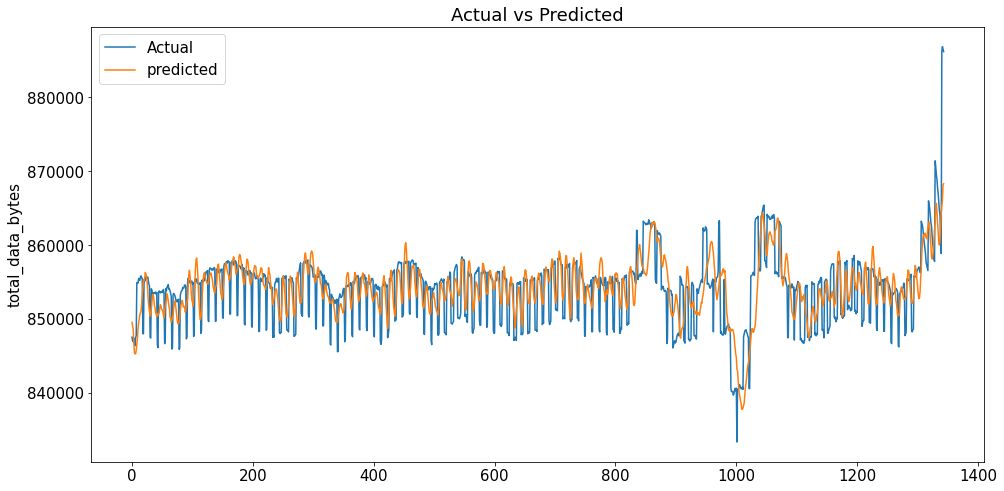

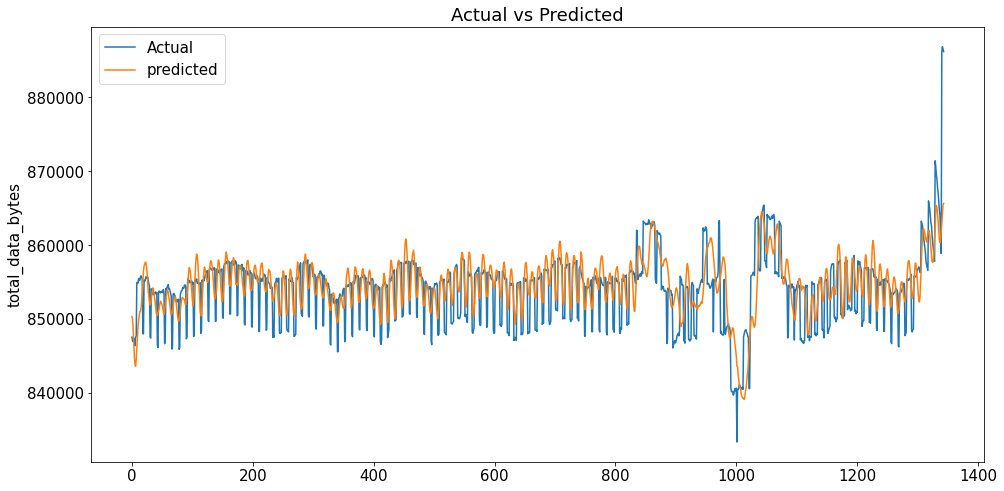


Day  3 :
MAE-E1D1 :  2697.5552,     MAE-E2D2 :  2710.1184
[847073.7  846956.75 847461.9  ... 886560.4  886194.44 886363.9 ]
[848977.   848503.8  848022.8  ... 865787.94 867644.7  868022.9 ]
MSE-E1D1 :  12988267.0, MSE-E2D2 :  13243678.0
RMSE-E1D1 :  3603.9238,     NRMSE-E1D1 :  0.0042581023,     RMSE-E2D2 :  3639.1865
MAPE-E1D1 :  0.31590177677571774,     MAPE-E2D2 :  0.317386188544333
R2 is  :  0.4496459587729784


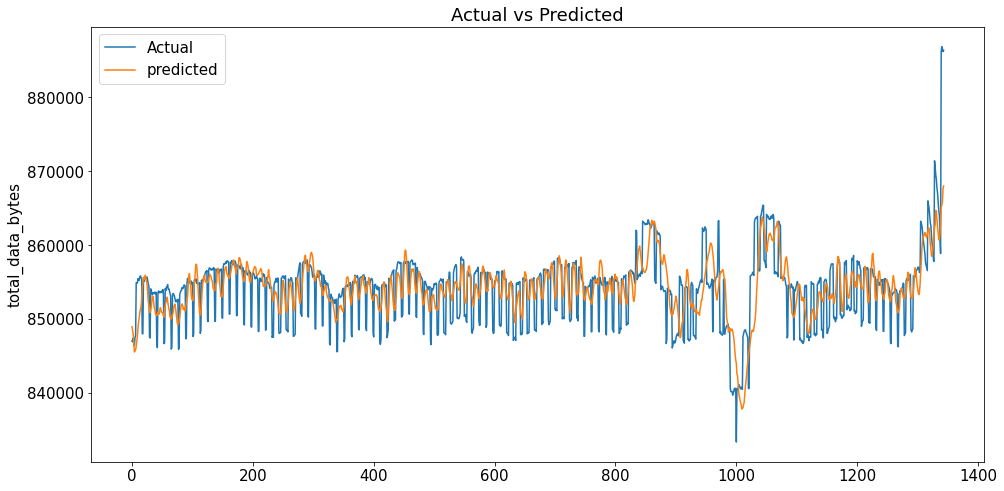

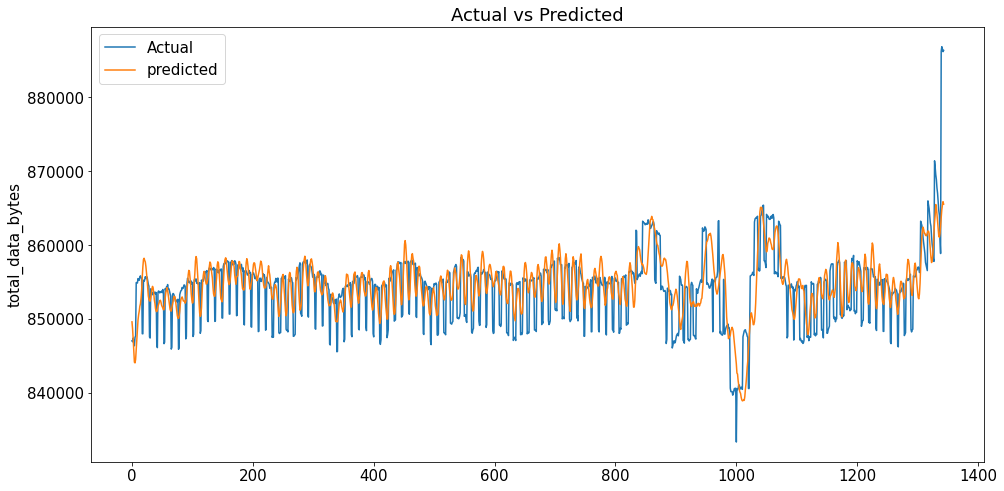


Day  4 :
MAE-E1D1 :  2791.4363,     MAE-E2D2 :  2749.3252
[846956.75 847461.9  846680.25 ... 886194.44 886363.9  888022.56]
[848317.   847858.4  847537.9  ... 865273.25 867112.   867872.  ]
MSE-E1D1 :  14164303.0, MSE-E2D2 :  13830546.0
RMSE-E1D1 :  3763.5493,     NRMSE-E1D1 :  0.004351481,     RMSE-E2D2 :  3718.944
MAPE-E1D1 :  0.32688919454813004,     MAPE-E2D2 :  0.32189679332077503
R2 is  :  0.44398423566172784


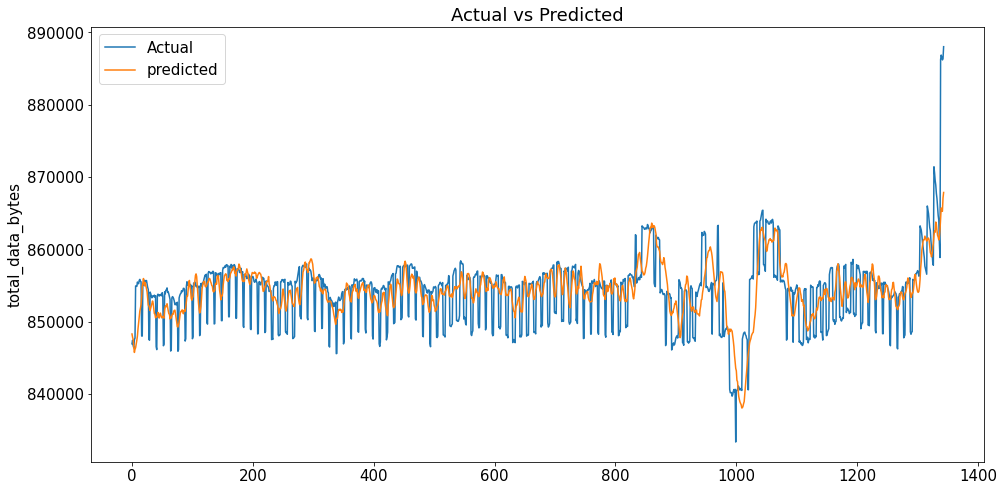

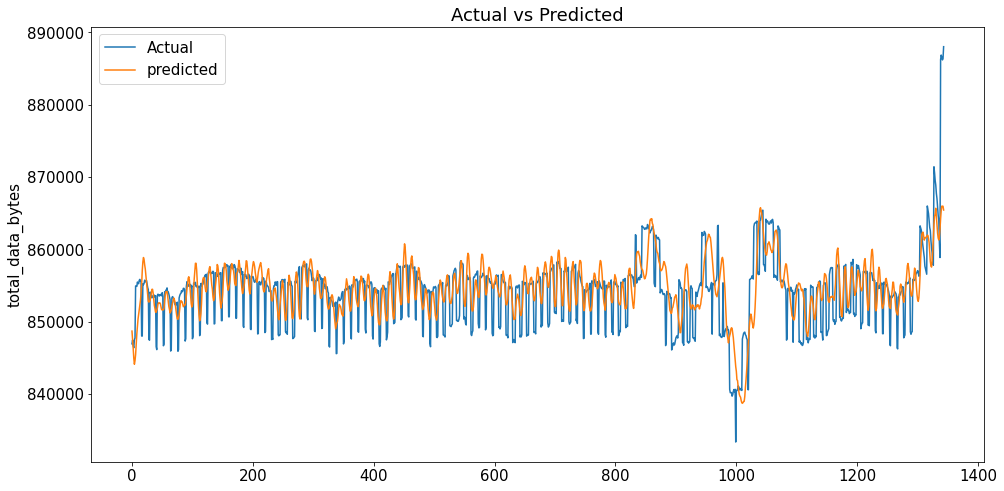


Day  5 :
MAE-E1D1 :  2857.503,     MAE-E2D2 :  2764.6167
[847461.9  846680.25 846404.   ... 886363.9  888022.56 888473.1 ]
[847674.9  847257.25 847121.7  ... 864616.75 866555.   867760.  ]
MSE-E1D1 :  15328613.0, MSE-E2D2 :  14398632.0
RMSE-E1D1 :  3915.1772,     NRMSE-E1D1 :  0.0044397768,     RMSE-E2D2 :  3794.553
MAPE-E1D1 :  0.3345957724377513,     MAPE-E2D2 :  0.32361806370317936
R2 is  :  0.4398394431901035


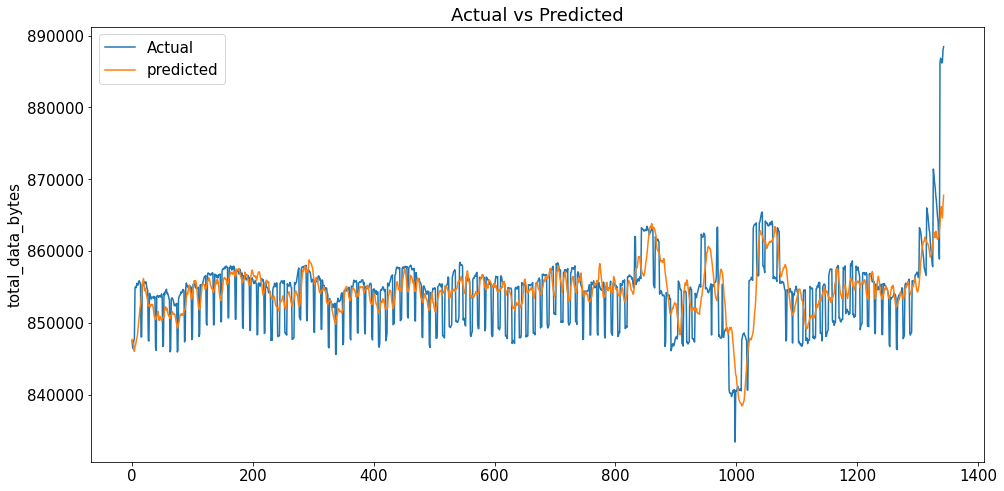

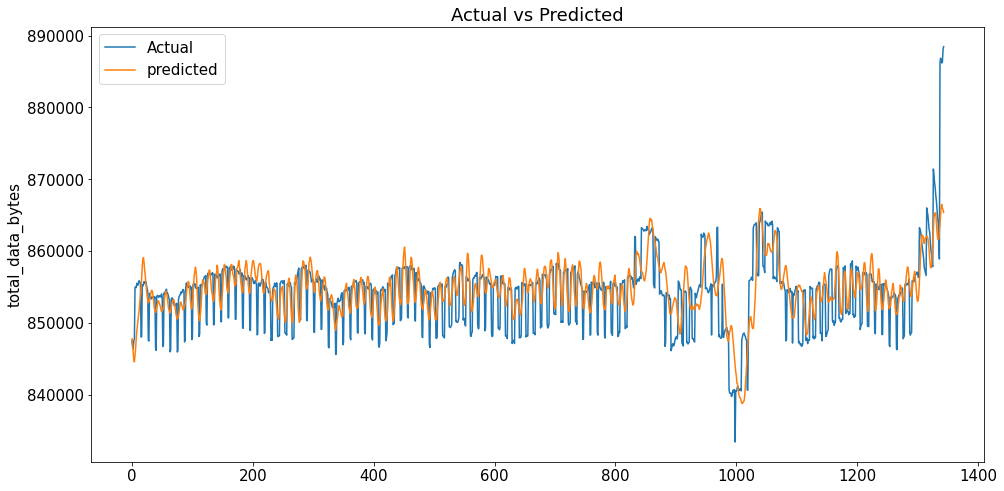

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from plotnine import ggplot, aes, geom_line
import matplotlib.pyplot as plt
from sklearn import metrics


def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
for index,i in enumerate(train_df.columns):
  print(i)
  
  for j in range(1,6):
  
   
    print()
    print("Day ",j,":")
   #print("Test-E1D1 : ",y_test[:,j-1,index])
    #print("Pred-E1D1 : ",pred1_e1d1[:,j-1,index])
    print("MAE-E1D1 : ",mean_absolute_error(y_test[:,j-1,index],pred1_e1d1[:,j-1,index]),end=",     ")
    print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))
    RMSE=np.sqrt(mean_squared_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))
 
    print (y_test[:,j-1,index])
    print (pred1_e1d1[:,j-1,index])
    
    print("MSE-E1D1 : ",mean_squared_error(y_test[:,j-1,index],pred1_e1d1[:,j-1,index]),end=", ")
    print("MSE-E2D2 : ",mean_squared_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))
    print("RMSE-E1D1 : ",np.sqrt(mean_squared_error(y_test[:,j-1,index],pred1_e1d1[:,j-1,index])),end=",     ")
    print("NRMSE-E1D1 : ", np.mean(np.sqrt(mean_squared_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))/pred1_e2d2[:,j-1,index]),end=",     ")
    #(np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))) * 10
    #(np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))) * 100 
    print("RMSE-E2D2 : ",np.sqrt(mean_squared_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index])))
    #print("RMSPE-E1D1 : ",(np.sqrt(np.mean(mean_squared_error(y_test[:,j-1,index],pred1_e1d1[:,j-1,index]))/y_test[:,j-1,index]))*100,end=",     ")
    #print("RMSPE-E2D2 : ",(np.sqrt(np.mean(mean_squared_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))/y_test[:,j-1,index]))*100)
    
    print("MAPE-E1D1 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred1_e1d1[:,j-1,index]),end=",     ")
    
    print("MAPE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))
    
    #print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    print("R2 is  : ",metrics.r2_score(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))
                   

    
    #plt.plot( list(y_test[2730:,j-1,index]),)
    #plt.plot( list(pred1_e1d1[2730:,j-1,index]))
    plt.plot( list(y_test[:,j-1,index]),)
    plt.plot( list(pred1_e1d1[:,j-1,index]))
    
    
    #plt.plot( list(pred1_e1d1[:,j-1,index]),kind='line', marker='d')
    
    #plt.bar(list(y_test[:,j-1,index] - list(pred1_e1d1[:,j-1,index])),10,2.5)
    #ax = plt.gca()
    #plt.xlim([y_test[:,j-1,index], list(pred1_e1d1[:,j-1,index]))
    
    #df = pd.DataFrame({'a': [100, 200, 150, 175],
    #               'b': [430, 30, 20, 10]})
    
    #df['b'].plot(kind='bar', color='y')
    #df['a'].plot(kind='line', marker='d')

    plt.title("Actual vs Predicted")
    plt.ylabel(i)
    plt.legend(('Actual','predicted'))
    plt.rcParams["figure.figsize"] = (16,8)
    plt.rcParams.update({'font.size': 15})
    plt.show()

    #plt.plot( list(y_test[2730:,j-1,index]),)
    #plt.plot( list(pred1_e2d2[2730:,j-1,index]))

    plt.plot( list(y_test[:,j-1,index]))
    plt.plot( list(pred1_e2d2[:,j-1,index]))
    
    plt.title("Actual vs Predicted")
    plt.ylabel(i)
    plt.legend(('Actual','predicted'))
    plt.show()
  print()
  print()
  

From the above output we can observe that in some cases E2D2 model has 
performed better than E1D1 model with less error. Training different models with different number of stacked layers and creating an ensemble model also performs well. 

Note: The results vary with respect to the dataset. If we stack more layers it may also lead to overfitting. So the no of layers to be stackes acts as a hyper parameter. 